In [ ]:
import pandas as _hex_pandas
import datetime as _hex_datetime
import json as _hex_json

In [ ]:
hex_scheduled = _hex_json.loads("false")

In [ ]:
hex_user_email = _hex_json.loads("\"example-user@example.com\"")

In [ ]:
hex_user_attributes = _hex_json.loads("{}")

In [ ]:
hex_run_context = _hex_json.loads("\"logic\"")

In [ ]:
hex_timezone = _hex_json.loads("\"UTC\"")

In [ ]:
hex_project_id = _hex_json.loads("\"4b0bb5c8-e47d-4256-b0b1-1eea21b25989\"")

In [ ]:
hex_project_name = _hex_json.loads("\"Monaco\"")

In [ ]:
hex_status = _hex_json.loads("\"\"")

In [ ]:
hex_categories = _hex_json.loads("[]")

In [ ]:
hex_color_palette = _hex_json.loads("[\"#4C78A8\",\"#F58518\",\"#E45756\",\"#72B7B2\",\"#54A24B\",\"#EECA3B\",\"#B279A2\",\"#FF9DA6\",\"#9D755D\",\"#BAB0AC\"]")

In [ ]:
import random
import math
import numpy as np
import time

In [ ]:
class Company:
    
    def __init__(self, name, stage, valuation, state, firm_invested_capital, firm_ownership, stages, valuations, dilution):
        self.name = name
        self.stage = stage
        self.valuation = valuation
        self.state = state
        self.firm_invested_capital = firm_invested_capital
        self.firm_ownership = firm_ownership
        self.market_constraints = {
            'stages': stages,
            'valuations': valuations,
            'dilution': dilution
        }
        self.age = 0
        
        ## Define logging state for initial investment
        self.initial_stage = (self.stage, self.firm_ownership)
        self.did_pro_rata = 0
        self.no_pro_rata_counter = {
            'out of reserved capital': 0,
            'too late stage': 0,
            'did pro rata':0
        }
    
    ## Promote this company to the next stage in its life
    def promote(self, secondary_dry_powder, pro_rata_at_or_below):
        
        ## Promote to the next stage and update states accordingly
        self.age += 1 #ZBG Question: confirming this is supposed to be "epochs" or essentially times it might have raised
        self.stage = self.market_constraints['stages'][min(self.market_constraints['stages'].index(self.stage) + 1, len(self.market_constraints['stages'])-1)] ## if already at last stage, stay at last stage #ZBG issue: this should throw an error if going beyond the last stage, instead of silencing the issue like this does
        self.valuation = self.market_constraints['valuations'][self.stage]

        ## Determine post-dilution ownership
        dilution = self.market_constraints['dilution'][self.stage] #ZBG issue: note there's no dilution for Pre-Seed, so presumably this returns NULL for that situation, which isn't exactly an error but it's incomplete logic
        post_dilution_ownership = self.firm_ownership*(1-dilution)
        
        ## If the fund does pro rata at this stage, and still has dry powder to contribute to secondaries, then determine pro rata investment
        ## This logic is included as part of the "Company" class (instead of the firm class) b/c each company requires a different amount of pro rata depending on investment history
        pro_rata_investment = 0
        if self.valuation <= pro_rata_at_or_below:
            if min((self.firm_ownership - post_dilution_ownership)*self.valuation, secondary_dry_powder) > 0:
                
                ## This is ugly tracking code - didn't have a lot of time
                self.did_pro_rata = 1 
                
                self.no_pro_rata_counter['did pro rata'] += 1 ## ZBGZBG: If you want to track the # of companies where we pass on pro rata instead of the # of times when we pass on pro rata, then make this "= 0" instead of "+= 0". Do same below
            else:
                self.no_pro_rata_counter['out of reserved capital'] += 1 ## ZBGZBG: If you want to track the # of companies where we pass on pro rata instead of the # of times when we pass on pro rata, then make this "= 0" instead of "+= 0". Do same below
            
            pro_rata_investment = min((self.firm_ownership - post_dilution_ownership)*self.valuation, secondary_dry_powder)
        
        else:
            self.no_pro_rata_counter['too late stage'] += 1 ## ZBGZBG: If you want to track the # of companies where we pass on pro rata instead of the # of times when we pass on pro rata, then make this "= 0" instead of "+= 0". Do same below

        self.firm_invested_capital += pro_rata_investment


        ## Update firm ownership based on dilution and pro rata
        self.firm_ownership = (self.firm_ownership*(1-dilution)) + pro_rata_investment/self.valuation ## existing ownership minus dilution plus pro rata investment ownership #ZBG issue: This applies dilution from a Seed round even if it's the first round in which Gradient invested, so it seems to dilute Gradient when it shouldn't
        
        return pro_rata_investment
            

    ## execute M&A for this company
    def m_and_a(self):

        ## Increment age and adjust stage
        self.age += 1
        self.state = "Acquired"

        ## M&A outcomes - todo: move these to global or montecarlo class
        ## 1% chance of 10x outcome, 2% chance of 5x outcome, 27% chance of 1x outcome, 70% chance of 0.5x outcome
        m_and_a_outcome_odds = [0.01, 0.05, 0.6, 0.34]
        m_and_a_multipliers = [10,5,1,0.1]  #[10,5,1,.5] #ZBG testing: putting in 1 for all to test
        
        ## Generate random value which determines M&A outcomes
        rand = random.random()
        if rand <m_and_a_outcome_odds[0]:
            # print('10x')
            self.valuation = m_and_a_multipliers[0]*self.valuation
        elif rand < m_and_a_outcome_odds[0]+m_and_a_outcome_odds[1]:
            # print('5x')
            self.valuation = m_and_a_multipliers[1]*self.valuation
        elif rand < m_and_a_outcome_odds[0]+m_and_a_outcome_odds[1]+m_and_a_outcome_odds[2]:
            # print('1x')
            self.valuation = m_and_a_multipliers[2]*self.valuation
        else:
            # print('0.5x')
            self.valuation = m_and_a_multipliers[3]*self.valuation
    
    
    def get_firm_value(self):
        return self.valuation * self.firm_ownership

    def fail(self):
        self.age += 1
        self.state = 'Failed'
        self.valuation = 0
    
    ## Function just for aging company - only used when a company is already failed or acquired, and we want to track age anyway
    def age_company(self):
        self.age += 1
    
    def get_numerical_stage(self):
        return self.market_constraints['stages'].index(self.stage)

    def __str__(self):
        return '[' + self.name + ', ' + self.stage + ', ' + str(self.valuation) + ', ' + self.state + ', ' + str(self.firm_invested_capital) + ', ' + str(self.firm_ownership) + ']'
    
    def __repr__(self):
        return '[' + self.name + ', ' + self.stage + ', ' + str(self.valuation) + ', ' + self.state + ', ' +  str(self.firm_ownership) + ',' + str(self.get_firm_value()) + ']\n'


In [ ]:
class Firm:
    ''' A firm is a collection of companies that it has invested in. It has a set of primary investments that it makes, a follow-on reserve, a fund size, and a lifespan in years.'''


    ## Create Firm object, set empty portfolio
    def __init__(self, name, primary_investments, follow_on_reserve, fund_size, firm_lifespan_years):
        self.name = name
        self.primary_investments = primary_investments
        self.follow_on_reserve = follow_on_reserve
        self.primary_capital_deployed = 0
        self.follow_on_capital_deployed = 0
        self.fund_size = fund_size
        self.firm_lifespan_years = firm_lifespan_years
        self.portfolio = []
        self.period_snapshots = []
    
    ## Initialize portfolio with full set of companies, with initial investments
    ## Take as input the full set of stages, valuations, and dilutions for each stage so that an individual company can run it's own operations on itself
    def initialize_portfolio(self, stages, valuations, dilution):
        
        ## For each primary investment type (e.g., pre-seed or seed)
        for primary_capital_rounds in self.primary_investments:
            ## What stage are we investing at
            stage_invested = primary_capital_rounds[0]
            
            ## How much are we investing in a company for a single investment
            capital_invested_per_company = primary_capital_rounds[1]

            ## How much total capital are we allocating at that stage
            capital_to_be_allocated = primary_capital_rounds[2]

            ## While we have capital left for this type of investment, initialize a company in the portfolio at that stage
            while capital_to_be_allocated > 0 and capital_to_be_allocated >= capital_invested_per_company:
                
                self.portfolio.append(Company('comp_name' + stage_invested[:2] + str(capital_to_be_allocated), 
                                            stage_invested, 
                                            valuations[stage_invested],
                                            'Alive', 
                                            capital_invested_per_company, 
                                            capital_invested_per_company/valuations[stage_invested],
                                            stages, 
                                            valuations, 
                                            dilution))
                
                ## We have just made an investment, so decrease the amount of remaining capital_to_be_allocated by how much we invested (capital_invested_per_company), and update the amount of primary capital deployed
                capital_to_be_allocated -= capital_invested_per_company
                self.primary_capital_deployed += capital_invested_per_company
        
        self.period_snapshots.append(self.get_detailed_portfolio_snapshot())
        
        # print('----------------------------------------------------------')
        # print('Initialized portfolio with', len(self.portfolio))
        # print('Pre-seed', len(list(filter(lambda x: x.stage == 'Pre-seed', self.portfolio))))
        # print('Seed', len(list(filter(lambda x: x.stage == 'Seed', self.portfolio))))
        # print('Series A', len(list(filter(lambda x: x.stage == 'Series A', self.portfolio))))
        # print('----------------------------------------------------------')
    
    
    ## Concise view of companies alive, failed, acquired
    def get_total_value_of_portfolio(self):
        total_value = 0
        for portco in self.portfolio:
            if portco.state == 'Alive':
                total_value += portco.valuation * portco.firm_ownership
            elif portco.state == 'Failed':
                total_value += 0
            elif portco.state == 'Acquired':
                total_value += portco.valuation * portco.firm_ownership
        return total_value

    ## 
    def get_detailed_portfolio_snapshot(self):
        snapshot = {
            'Pre-seed':0,
            'Seed':0,
            'Series A': 0,
            'Series B': 0,
            'Series C': 0,
            'Series D': 0,
            'Series E': 0,
            'Series F': 0,
            'Series G':0,
            'Alive': 0,
            'Acquired': 0,
            'Failed': 0, 
            'MOC': self.detailed_portfolio_value()
        }
        for portco in self.portfolio:
            if portco.state == 'Alive':
                snapshot[portco.stage] += 1
                snapshot['Alive'] +=1
            elif portco.state == 'Acquired':
                snapshot['Acquired'] += 1
            elif portco.state == 'Failed':
                snapshot['Failed'] += 1
        return snapshot

    
    def detailed_portfolio_value(self):
        
        total_value = {
            'Alive': 0,
            'Acquired': 0
        }
        for portco in self.portfolio:
            # print(portco.stage, portco.state, '-- val', portco.valuation, 'return', portco.valuation*portco.firm_ownership, 'ic', portco.firm_invested_capital, 'ownership', portco.firm_ownership)
            if portco.state == 'Alive':
                total_value['Alive'] += portco.valuation * portco.firm_ownership
            elif portco.state == 'Acquired':
                total_value['Acquired'] += portco.valuation * portco.firm_ownership
        return total_value

    
    def get_capital_invested(self):
        return self.primary_capital_deployed + self.follow_on_capital_deployed
    
    def get_remaining_follow_on_capital(self):
        return self.follow_on_reserve - self.follow_on_capital_deployed
    
    def get_irr(self):
        # fv = self.get_total_value_of_portfolio()
        # pv = self.primary_capital_deployed + self.follow_on_capital_deployed
        # # print(fv, pv)
        # IRR = ((fv / pv) ** (1/self.firm_lifespan_years)) -1
        # return IRR
        print ('ERROR: ' + 'IRR not implemented')

    def get_MoM(self):
        MoM = round(self.get_total_value_of_portfolio()/self.get_capital_invested(), 1)
        return MoM
    
    def get_stratified_returns(self):
        pass
        # stratified_returns = {
        #     'Alive': 0,
        #     'Acquired': 0,
        #     'Total':0
        # }

        # for portco in self.portfolio:
            
        #     if portco.state == 'Alive':
        #         stratified_returns['Alive'] += portco.get_firm_value()
        #         stratified_returns['Total'] += portco.get_firm_value()
        #     elif portco.state == 'Acquired':
        #         stratified_returns['Alive'] += portco.get_firm_value()
        #         stratified_returns['Total'] += portco.get_firm_value()
        #     elif portco.state == 'Failed':
        #         stratified_returns['Total'] += portco.get_firm_value()
        
    
    def __repr__(self):
        return self.get_detailed_portfolio_snapshot()
    


In [ ]:
class Montecarlo:
    ''' The Montecarlo class simulates a firm's investing lifecycle'''
    
    # def __init__(self, num_scenarios, stages, stage_probs, stage_valuations, stage_dilution, firm_attributes):
    # def __init__(self, num_scenarios, stages, stage_probs, stage_valuations, stage_dilution, firm_attributes):
        
    #     ## Each scenario is a firm that is simulated from the initialization of their portfolio to the end of their funds lifespan (i.e., after ~10yrs)
    #     self.num_scenarios = num_scenarios
    #     self.firm_scenarios = []
        
    #     ## These are all variables that are needed to calculate the probability of companies moving on to the next stage, the corresponding dilution, and valuations
    #     self.stages = stages
    #     self.stage_probs = stage_probs
    #     self.stage_valuations = stage_valuations
    #     self.stage_dilution = stage_dilution
        
    #     ## Firm attributes contain information about firm's entry point (e.g., pre-seed vs seed), fund size, primary vs. follow-on capital
    #     self.firm_attributes = firm_attributes

    def __init__(self, config):
        ## Each scenario is a firm that is simulated from the initialization of their portfolio to the end of their funds lifespan (i.e., after ~10yrs)
        self.config = config
        self.num_scenarios = config.num_scenarios
        self.firm_scenarios = []
        
        ## These are all variables that are needed to calculate the probability of companies moving on to the next stage, the corresponding dilution, and valuations
        self.stages = config.stages
        self.stage_probs = config.graduation_rates
        self.stage_valuations = config.stage_valuations
        self.stage_dilution = config.stage_dilution
        
        ## Firm attributes contain information about firm's entry point (e.g., pre-seed vs seed), fund size, primary vs. follow-on capital
        self.firm_attributes = {
            'primary_investments': [],
            'follow_on_reserve': config.follow_on_reserve,
            'fund_size': config.fund_size,
            'firm_lifespan_periods': config.lifespan_periods,
            'firm_lifespan_years': config.lifespan_years,
            'pro_rata_at_or_below': config.pro_rata_at_or_below
        }
        
        for stage in config.primary_investments.keys():
            self.firm_attributes['primary_investments'].append([stage, config.initial_investment_sizes[stage], config.primary_investments[stage]])
        
        self.config_name = 'No Name Yet'
    
    def initialize_scenarios(self):

        ## Initialize the firm_scenarios list with a new firm for each simulated scenario
        for i in range(self.num_scenarios):
            
            ## Create the firm object
            new_firm = Firm('Gradient'+ str(i), 
                            self.firm_attributes['primary_investments'], 
                            self.firm_attributes['follow_on_reserve'], 
                            self.firm_attributes['fund_size'], 
                            self.firm_attributes['firm_lifespan_years'])
            
            ## Initialize the portfolio inside that firm
            new_firm.initialize_portfolio(self.stages, self.stage_valuations, self.stage_dilution)
            self.firm_scenarios.append(new_firm)
        
    
    ################################################################################################################################################################################################
    ################################################################ Contains core simulation logic for Montecarlo simulation ######################################################################
    ################################################################################################################################################################################################
    def simulate(self):
        ## Re-seed random number generator 
        random.seed(time.time())

        ## For each firm that we want to simulate, run the simulation
        for firm in self.firm_scenarios:
            ## Iteratively age companies in portfolio, deploying any secondary capital available, and rendering a judgement based on random outcomes about how a company performs
            ## Each portfolio is aged for a set number of periods, which for the purposes of this simulation, is roughly 11 / 1.5yrs = 7 periods
            for period in range(self.firm_attributes['firm_lifespan_periods']):
                
                ## For each company in the portfolio, determine whether to promote, fail, or M&A based on random performance
                for company in firm.portfolio:
                    
                    ## If company is still alive, determine action based on random + probabilities calculation
                    ## Probabilities in order of [next round, fail, M&A]
                    if company.state == 'Alive' and company.get_numerical_stage() < len(self.stages)-1:
                        rand = random.random()
                        # print ('Company', rand, self.stage_probs[company.stage][0])
                        if rand < self.stage_probs[company.stage][2]:
                            company.m_and_a()
                        elif rand < self.stage_probs[company.stage][2] + self.stage_probs[company.stage][1]:
                            company.fail()
                        else: 
                            secondary_capital_consumed = company.promote(firm.get_remaining_follow_on_capital(), self.firm_attributes['pro_rata_at_or_below'])
                            firm.follow_on_capital_deployed += secondary_capital_consumed
                    
                    ## If already failed or acquired, just increment age
                    elif company.state == 'Failed':
                        company.age_company()
                    elif company.state == 'Acquired':
                        company.age_company()
                
                ## TAKE A SNAPSHOT
                firm.period_snapshots.append(firm.get_detailed_portfolio_snapshot())
        
            
            ## If we didn't use all of our pro rata b/c our portfolio didn't do well, deploy remaining capital as primary investments
            #### This is a clunky implementation (as a fund wouldn't know in advance if they had allocated too much reserves), but we 
            #### assume that any reasonable fund would track their expected follow-on deployment and make additional primary investments
            #### if they felt they wouldn't hit their secondary follow on targets
            if firm.get_remaining_follow_on_capital() > 0:
                # print("Firm had remaining capital:", firm.get_remaining_follow_on_capital())
                extra_investments = []
                extra_investment_type = self.firm_attributes['primary_investments'][0]
                num_extra_investments = int(firm.get_remaining_follow_on_capital() // extra_investment_type[1])
                for extra_investment_index in range (num_extra_investments):
                    extra_investments.append(Company('extra' + str(extra_investment_index), 
                                            extra_investment_type[0], 
                                            self.stage_valuations[extra_investment_type[0]],
                                            'Alive', 
                                            extra_investment_type[1], 
                                            extra_investment_type[1]/self.stage_valuations[extra_investment_type[0]],
                                            self.stages, 
                                            self.stage_valuations, 
                                            self.stage_dilution))
                    firm.primary_capital_deployed += extra_investment_type[1]
                    firm.follow_on_reserve -= extra_investment_type[1]

                for period in range(self.firm_attributes['firm_lifespan_periods']):
                    for company in extra_investments:
                        if company.state == 'Alive' and company.get_numerical_stage() < len(self.stages)-1:
                            rand = random.random()
                            # print ('Company', rand, self.stage_probs[company.stage][0])
                            if rand < self.stage_probs[company.stage][2]:
                                company.m_and_a()
                            elif rand < self.stage_probs[company.stage][2] + self.stage_probs[company.stage][1]:
                                company.fail()
                            else: 
                                # No secondary capital available b/c this is the "extra" batch of companies
                                company.promote(0, self.firm_attributes['pro_rata_at_or_below'])
                        elif company.state == 'Failed':
                            company.age_company()
                        elif company.state == 'Acquired':
                            company.age_company()
                firm.portfolio += extra_investments

    def get_IRR_return_outcomes(self):
        print('ERROR: ' + 'IRR not implemented')

    def get_MoM_return_outcomes(self):
        outcomes = []
        for firm in self.firm_scenarios:
            outcomes.append(firm.get_MoM())
        return outcomes
    
    def get_median_return_outcome(self, type):
        outcomes = []
        if type == 'MoM':
            outcomes = self.get_MoM_return_outcomes()
        elif type == 'IRR':
            outcomes = self.get_IRR_return_outcomes()
        if len(outcomes) % 2 == 0:
            return (outcomes[len(outcomes)//2] + outcomes[len(outcomes)//2 - 1])/2
        else:
            return outcomes[len(outcomes)//2]

    def get_exact_return_outcomes(self):
        outcomes = []
        for firm in self.firm_scenarios:
            outcomes.append(firm.get_total_value_of_portfolio())
        return outcomes

    
    def performance_quartiles(self):
        
        outcomes = self.get_MoM_return_outcomes()
        performance = {}
        
        performance['25'] = [str(np.percentile(outcomes, 25))]
        performance['50'] = [str(np.percentile(outcomes, 50))]
        performance['75'] = [str(np.percentile(outcomes, 75))]
        performance['90'] = [str(np.percentile(outcomes, 90))]
        performance['95'] = [str(np.percentile(outcomes, 95))]

        return performance

    def get_total_value_acquired(self):
        total_value_acquired = 0
        for firm in self.firm_scenarios:
            for portco in firm.portfolio:
                if portco.state == 'Acquired':
                    total_value_acquired += portco.get_firm_value()
        return total_value_acquired
    
    def get_total_value_alive(self):
        total_value_alive = 0
        for firm in self.firm_scenarios:
            for portco in firm.portfolio:
                if portco.state == 'Alive':
                    total_value_alive += portco.get_firm_value()
        return total_value_alive
    


    def get_total_companies_by_stage(self):
        stage_counter = {
            'Pre-seed': 0,
            'Seed': 0,
            'Series A': 0,
            'Series B': 0,
            'Series C': 0,
            'Series D': 0,
            'Series E': 0,
            'Series F': 0,
            'Series G': 0
        }
        for firm in self.firm_scenarios:
            for portco in firm.portfolio:
                stage_counter[portco.stage] += 1
        return stage_counter

    def get_total_companies_by_state(self):
        state_counter = {
            'Alive': 0,
            'Failed': 0,
            'Acquired': 0
        }
        for firm in self.firm_scenarios:
            for portco in firm.portfolio:
                state_counter[portco.state] += 1
        return state_counter

    def get_total_companies_pro_rata(self):
        state_counter = {
            'Pro Rata': 0,
            'No Pro Rata': 0
        }
        for firm in self.firm_scenarios:
            for portco in firm.portfolio:
                if portco.did_pro_rata == 1:
                    state_counter['Pro Rata'] += 1
                else:
                    state_counter['No Pro Rata'] += 1
        return state_counter
    
    def get_no_pro_rata_outcomes(self):
        no_pro_rata_counter = {
            'out of reserved capital': 0,
            'too late stage': 0,
            'did pro rata': 0,
        }
        for firm in self.firm_scenarios:
            for portco in firm.portfolio:
                no_pro_rata_counter['out of reserved capital'] += portco.no_pro_rata_counter['out of reserved capital']
                no_pro_rata_counter['too late stage'] += portco.no_pro_rata_counter['too late stage']
                no_pro_rata_counter['did pro rata'] += portco.no_pro_rata_counter['did pro rata']
        return no_pro_rata_counter

    def get_average_number_of_companies_post_pro_rata_adjustment(self):
        lengths = []
        for firm in self.firm_scenarios:
            lengths.append(len(firm.portfolio))
        
        return sum(lengths) / len(lengths)


    def montecarlo_histogram(self):
        ''' Histogram for montecarlo simulation - very ugly code optimized for  being able to combine multiple hisograms across different simulations'''
        
        histogram = {}
        outcomes = self.get_MoM_return_outcomes()
        hist_size = .25
        counter = 0.0
        upper_limit = 15
        while counter < upper_limit:
            relevant = list(filter(lambda y: counter <= y < counter+hist_size, outcomes))
            histogram[f"{counter}-{counter+hist_size}"] = [str(len(relevant))]
            counter += hist_size
        
        return histogram

    
    def get_montecarlo_outcomes_overview(self):
        return {
            'Num Simulations': self.num_scenarios,
            'Fund Size': self.firm_attributes['fund_size'],
            'Initial Investment': self.firm_attributes['primary_investments'],
            'Follow on': self.firm_attributes['follow_on_reserve'],
            'Median MoM': self.get_median_return_outcome('MoM')
        }

    def print_results(self):
        print(f"Montecarlo Simulation Results ({self.num_scenarios} scenarios):")
        for i, scenario in enumerate(self.firm_scenarios, start=1):
            print(f"Scenario {i}: {scenario}")
    
    def get_individual_montecarlo_simulation_inputs_and_outputs(self):
        results = []
        for x, firm in enumerate(self.firm_scenarios):

            ## identify pre-seed vs. seed split at initial check
            ## identify value from companies that started pre-seed vs. seed
            pre_seed_investments = 0
            pre_seed_ending_value = 0
            seed_investments = 0
            seed_ending_value = 0
            for portco in firm.portfolio:
                if portco.initial_stage[0] == 'Pre-seed':
                    pre_seed_investments += 1
                    pre_seed_ending_value +=  portco.get_firm_value()
                elif portco.initial_stage[0] == 'Seed':
                    seed_investments += 1
                    seed_ending_value += portco.get_firm_value()            
            
            ## identify % of companies that Succeed, fail, M&A
            ## identify value of companies that Succeed, fail, M&A
            alive_number = 0
            alive_value = 0
            fail_number = 0
            acquired_number = 0
            acquired_value = 0
            for portco in firm.portfolio:
                if portco.state == 'Alive':
                    alive_number += 1
                    alive_value += portco.get_firm_value()
                elif portco.state == 'Failed':
                    fail_number += 1
                elif portco.state == 'Acquired':
                    acquired_number += 1
                    acquired_value += portco.get_firm_value()

            results.append({
                'Overall': {
                    'MOIC': firm.get_MoM(),
                    'Total companies': len(firm.portfolio)
                }, 
                'Initial Investments & Outcomes': {
                    'Pre-seed': (pre_seed_investments, pre_seed_ending_value),
                    'Seed': (seed_investments, seed_ending_value)
                },
                'Outcomes': {
                    'Alive': (alive_number, alive_value),
                    'Failed': (fail_number, 0),
                    'Acquired': (acquired_number, acquired_value)
                }
            })
        return results
            

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from collections import OrderedDict


class Montecarlo_Sim_Configuration():
    def __init__(self, stages, graduation_rates, stage_dilution, stage_valuations, lifespan_periods, lifespan_years, primary_investments, initial_investment_sizes, follow_on_reserve, fund_size, pro_rata_at_or_below, num_scenarios):
        ## Market variables
        self.stages = stages
        self.graduation_rates = graduation_rates.copy()
        self.stage_dilution = stage_dilution.copy()
        self.stage_valuations = stage_valuations.copy()
        self.lifespan_periods = lifespan_periods
        self.lifespan_years = lifespan_years
        
        ## Investment Strategy
        self.primary_investments = primary_investments.copy() ## Input should look like { 'Pre-seed': 30, 'Seed': 170}
        self.initial_investment_sizes = initial_investment_sizes.copy()
        self.follow_on_reserve = follow_on_reserve
        self.fund_size = fund_size
        self.pro_rata_at_or_below = pro_rata_at_or_below

        ## Make minor tweaks to investment strategy to ensure montecarlo simulations runs successfully
        self.make_minor_round_size_adjustments_for_modeling()


        ## Montecarlo Simulation variables
        self.num_scenarios = num_scenarios
    
    def make_minor_round_size_adjustments_for_modeling(self):
        
        add_to_follow_on_reserve = 0
        for stage in self.primary_investments.keys():
            if stage not in self.initial_investment_sizes or self.initial_investment_sizes[stage] == 0:
                print(f"Error: Missing or zero initial investment size for stage {stage}")
                continue
    
            total_amount_to_invest = (self.primary_investments[stage] // self.initial_investment_sizes[stage]) * self.initial_investment_sizes[stage]
            remainder = self.primary_investments[stage] - total_amount_to_invest
            self.primary_investments[stage] = total_amount_to_invest
            add_to_follow_on_reserve += remainder
            
        # for stage in self.primary_investments.keys():
        #     total_amount_to_invest = (self.primary_investments[stage] // self.initial_investment_sizes[stage]) * self.initial_investment_sizes[stage]
        #     remainder = self.primary_investments[stage] - total_amount_to_invest
        #     self.primary_investments[stage] = total_amount_to_invest
        #     add_to_follow_on_reserve += remainder
        
        self.follow_on_reserve += add_to_follow_on_reserve


        total_plan_to_invest = 0
        for stage in self.primary_investments.keys():
            total_plan_to_invest += self.primary_investments[stage]
        total_plan_to_invest += self.follow_on_reserve
        if total_plan_to_invest != self.fund_size:
            print('Error: Total primary investment plus follow-on reserve does not equal fund size x222222')
            return None
            
            
            
    
    def __repr__(self):
        return (
            f"Montecarlo_Sim_Configuration(\n"
            f"  Fund Size: ${self.fund_size}M\n"
            f"  Primary Investments: {self.primary_investments}\n"
            f"  Initial Investment Sizes: {self.initial_investment_sizes}\n"
            f"  Follow-on Reserve: ${self.follow_on_reserve}M\n"
            f"  Pro-rata at or below: ${self.pro_rata_at_or_below}M\n"
            f"  Lifespan: {self.lifespan_years} years ({self.lifespan_periods} periods)\n"
            f"  Num Scenarios: {self.num_scenarios}\n"
            f"  Graduation Rates: {self._format_dict(self.graduation_rates)}\n"
            f"  Stage Dilution: {self._format_dict(self.stage_dilution)}\n"
            f"  Stage Valuations: {self._format_dict(self.stage_valuations)}\n"
            f")"
        )

    def _format_dict(self, d):
        return "{\n    " + "\n    ".join(f"{k}: {v}" for k, v in d.items()) + "\n  }"




class Experiment:
    def __init__(self):
            self.output_variables = OrderedDict([
                ('fund_size', {'name': 'Fund Size', 'format': '${:,.0f}M'}),
                ('follow_on_reserve', {'name': 'Follow-on Capital Reserved', 'format': '${:,.0f}M'}),
                ('pro_rata_at_or_below', {'name': 'Pro-Rata Valuation Threshold', 'format': '${:,.0f}M'}),
                ('Pre-seed_investment_amount', {'name': 'Initial Pre-seed Check Size', 'format': '${:,.1f}M'}),
                ('Seed_investment_amount', {'name': 'Initial Seed Check Size', 'format': '${:,.1f}M'}),
                ('Pre-seed_total_invested', {'name': 'Total Pre-seed Capital Deployed', 'format': '${:,.0f}M'}),
                ('Seed_total_invested', {'name': 'Total Seed Capital Deployed', 'format': '${:,.0f}M'}),
                ('Pre-seed_avg_ownership', {'name': 'Pre-seed Avg Ownership (initial)', 'format': '{:.2f}%'}),
                ('Seed_avg_ownership', {'name': 'Seed Avg Ownership (initial)', 'format': '{:.2f}%'}),
                ('overall_avg_ownership', {'name': 'Overall Ownership (initial)', 'format': '{:.2f}%'}),
                ('avg_portfolio_size', {'name': 'Avg actual portfolio size', 'format': '{:.1f}'}),
                ('total_portfolio_companies', {'name': 'Total # of Portfolio Companies', 'format': '{:,.0f}'}),
                ('Pre-seed_avg_companies', {'name': '# of Pre-seed Companies (original)', 'format': '{:,.0f}'}),
                ('Seed_avg_companies', {'name': '# of Seed Companies (original)', 'format': '{:,.0f}'}),
                ('Pre-seed_companies', {'name': '# of Pre-seed Companies', 'format': '{:,.0f}'}),
                ('Seed_companies', {'name': '# of Seed Companies', 'format': '{:,.0f}'}),
                ('Series A_companies', {'name': '# of Series A Companies', 'format': '{:,.0f}'}),
                ('Series B_companies', {'name': '# of Series B Companies', 'format': '{:,.0f}'}),
                ('Series C_companies', {'name': '# of Series C Companies', 'format': '{:,.0f}'}),
                ('Series D_companies', {'name': '# of Series D Companies', 'format': '{:,.0f}'}),
                ('Series E_companies', {'name': '# of Series E Companies', 'format': '{:,.0f}'}),
                ('Series F_companies', {'name': '# of Series F Companies', 'format': '{:,.0f}'}),
                ('Series G_companies', {'name': '# of Series G Companies', 'format': '{:,.0f}'}),
                ('Alive Companies', {'name': '# of Alive Companies', 'format': '{:,.0f}'}),
                ('Failed Companies', {'name': '# of Failed Companies', 'format': '{:,.0f}'}),
                ('Acquired Companies', {'name': '# of Acquired Companies', 'format': '{:,.0f}'}),
                ('Pro Rata Companies', {'name': '# of Pro Rata Companies', 'format': '{:,.0f}'}),
                ('No Pro Rata Companies', {'name': '# of No Pro Rata Companies', 'format': '{:,.0f}'}),
                ('# times pro rata', {'name': '# of times pro rata', 'format': '{:,.0f}'}),
                ('# times pass on pro rata: out of reserved capital', {'name': '# times pass on pro rata: out of reserved capital', 'format': '{:,.0f}'}),
                ('# times pass on pro rata: too late stage', {'name': '# times pass on pro rata: too late stage', 'format': '{:,.0f}'}),
                ('total_value_acquired', {'name': 'Total Value from Acquired Companies', 'format': '${:,.0f}M'}),
                ('total_value_alive', {'name': 'Total Value from Alive Companies', 'format': '${:,.0f}M'}),
                ('25th_percentile', {'name': '25th Percentile MOIC', 'format': '{:.2f}x'}),
                ('50th_percentile', {'name': '50th Percentile MOIC', 'format': '{:.2f}x'}),
                ('75th_percentile', {'name': '75th Percentile MOIC', 'format': '{:.2f}x'}),
                ('90th_percentile', {'name': '90th Percentile MOIC', 'format': '{:.2f}x'}),
                ('total_MOIC', {'name': 'Total MOIC (mean)', 'format': '{:.2f}x'}),
            ])

    def generate_montecarlo_configurations(self, config_options):
        """
        Generate multiple Montecarlo_Sim_Configuration objects based on the provided options.
        
        :param config_options: A dictionary containing configuration options.
                               Each value can be a single value or an array of options.
        :return: An array of Montecarlo_Sim_Configuration objects.
        """
        # Separate single values and arrays, but keep 'stages' as a single value
        single_values = {k: v for k, v in config_options.items() if not isinstance(v, list) or k == 'stages'}
        array_options = {k: v for k, v in config_options.items() if isinstance(v, list) and k != 'stages'}

        # Generate all combinations of array options
        option_names = list(array_options.keys())
        option_values = list(array_options.values())
        combinations = list(itertools.product(*option_values))

        configurations = []
        for combination in combinations:
            # Create a new dictionary for each combination
            config = single_values.copy()
            config.update(dict(zip(option_names, combination)))

            # Create Montecarlo_Sim_Configuration object
            mc_config = self.create_montecarlo_sim_configuration(config)
            if mc_config:
                configurations.append(mc_config)

        return configurations

    def create_montecarlo_sim_configuration(self, config):
        """
        Create a single Montecarlo_Sim_Configuration object from a configuration dictionary.
        Includes validation checks for primary investments and fund size.
        """
        try:
            # Ensure stages is a list
            if isinstance(config['stages'], str):
                config['stages'] = [config['stages']]
            
            # Calculate total primary investment
            total_primary_investment = sum(config['primary_investments'].values())

            # Validate primary investments and follow-on reserve
            if total_primary_investment + config['follow_on_reserve'] != config['fund_size']:
                print('Error: Total primary investment plus follow-on reserve does not equal fund size')
                print('Error details:', 'follow_on_reserve=' + str(config['follow_on_reserve']), 'total_primary_investment=' + str(total_primary_investment),'and fund_size=' + str(config['fund_size']))
                print ('Error details:', config['primary_investments'])
                return None

            # Validate initial investment sizes
            # for stage, amount in config['initial_investment_sizes'].items():
            #     if stage in config['primary_investments']:
            #         total_invested = config['primary_investments'][stage]
            #         if total_invested % amount != 0:
            #             print(f'Error: {stage} total investment is not divisible by initial investment size')
            #             return None

            # Validate that all primary investment stages are included in the stages list
            if not set(config['primary_investments'].keys()).issubset(set(config['stages'])):
                print('Error: Not all primary investment stages are included in the stages list')
                print(f"Stages: {config['stages']}")
                print(f"Primary investment stages: {list(config['primary_investments'].keys())}")
                return None

            # Create and return the Montecarlo_Sim_Configuration object
            return Montecarlo_Sim_Configuration(
                stages=config['stages'],
                graduation_rates=config['graduation_rates'],
                stage_dilution=config['stage_dilution'],
                stage_valuations=config['stage_valuations'],
                lifespan_periods=config['lifespan_periods'],
                lifespan_years=config['lifespan_years'],
                primary_investments=config['primary_investments'],
                initial_investment_sizes=config['initial_investment_sizes'],
                follow_on_reserve=config['follow_on_reserve'],
                fund_size=config['fund_size'],
                pro_rata_at_or_below=config['pro_rata_at_or_below'],
                num_scenarios=config['num_scenarios']
            )
        except KeyError as e:
            print(f"Missing required configuration parameter: {e}")
            return None

    def run_montecarlo(self, config):
        if config.follow_on_reserve + sum(config.primary_investments.values()) != config.fund_size:
            print('Error: Fund size does not match capital allocation', config.primary_investments, config.follow_on_reserve, config.fund_size)
            return None

        if config.lifespan_periods != len(config.stages)-1 or len(config.stages) != len(config.stage_valuations.keys()) or len(config.stages) != len(config.graduation_rates.keys()):
            print('Error: Stages do not match probabilities, valuations, or firm lifespan')
            return None

        montecarlo = Montecarlo(config)
        montecarlo.initialize_scenarios()
        montecarlo.simulate()

        return self.get_simulation_outcome(montecarlo)

    def simulate_multiple_firm_strategies(self, configs):
        results = []
        for i, config in enumerate(configs, 1):
            print(f"Simulating Strategy {i}")
            result = self.run_montecarlo(config)
            
            if result is not None:
                result['Strategy'] = f'Strategy {i}'
                results.append(result)

        return results

    def get_simulation_outcome(self, montecarlo):
        # This method should be implemented to process the results of the Montecarlo simulation
        # For now, we'll return a placeholder
        return {"Strategy": "Placeholder", "Outcome": "Simulation completed"}
    
    def get_simulation_outcome(self, montecarlo):
        if not montecarlo:
            return None

        config = montecarlo.config
        outcomes = montecarlo.get_MoM_return_outcomes()

        result = {}

        # Basic config values
        result['fund_size'] = config.fund_size
        result['follow_on_reserve'] = config.follow_on_reserve
        result['pro_rata_at_or_below'] = config.pro_rata_at_or_below

        # Investment amounts and totals
        for stage in ['Pre-seed', 'Seed']:
            result[f'{stage}_investment_amount'] = config.initial_investment_sizes.get(stage, 0)
            result[f'{stage}_total_invested'] = config.primary_investments.get(stage, 0)

        # Ownership calculations
        total_ownership = 0
        total_companies = 0
        for stage in ['Pre-seed', 'Seed']:
            if stage in config.primary_investments and stage in config.stage_valuations:
                amount = config.initial_investment_sizes[stage]
                valuation = config.stage_valuations[stage]
                ownership = (amount / valuation) * 100
                num_companies = config.primary_investments[stage] / amount
                result[f'{stage}_avg_ownership'] = ownership
                result[f'{stage}_avg_companies'] = num_companies
                total_ownership += ownership * num_companies
                total_companies += num_companies

        result['overall_avg_ownership'] = total_ownership / total_companies if total_companies > 0 else 0
        result['total_portfolio_companies'] = total_companies

        # Portfolio size
        result['avg_portfolio_size'] = montecarlo.get_average_number_of_companies_post_pro_rata_adjustment()

        # Company counts
        stage_counter = montecarlo.get_total_companies_by_stage()
        for stage in config.stages:
            result[f'{stage}_companies'] = stage_counter.get(stage, 0)

        state_counter = montecarlo.get_total_companies_by_state()
        result['Alive Companies'] = state_counter['Alive']
        result['Failed Companies'] = state_counter['Failed']
        result['Acquired Companies'] = state_counter['Acquired']

        pro_rata_counter = montecarlo.get_total_companies_pro_rata()
        result['Pro Rata Companies'] = pro_rata_counter['Pro Rata']
        result['No Pro Rata Companies'] = pro_rata_counter['No Pro Rata']

        pro_rata_pass_counter = montecarlo.get_no_pro_rata_outcomes()
        result['# times pass on pro rata: out of reserved capital'] = pro_rata_pass_counter['out of reserved capital']
        result['# times pass on pro rata: too late stage'] = pro_rata_pass_counter['too late stage']
        result['# times pro rata'] = pro_rata_pass_counter['did pro rata']

        # Value calculations
        result['total_value_acquired'] = montecarlo.get_total_value_acquired()
        result['total_value_alive'] = montecarlo.get_total_value_alive()

        # MOIC calculations
        result['25th_percentile'] = np.percentile(outcomes, 25)
        result['50th_percentile'] = np.percentile(outcomes, 50)
        result['75th_percentile'] = np.percentile(outcomes, 75)
        result['90th_percentile'] = np.percentile(outcomes, 90)
        result['total_MOIC'] = np.mean(outcomes)

        return result

    def run_montecarlo(self, config):
        if config.follow_on_reserve + sum(config.primary_investments.values()) != config.fund_size:
            print('Error: Fund size does not match capital allocation', config.primary_investments, config.follow_on_reserve, config.fund_size)
            return None

        if config.lifespan_periods != len(config.stages)-1 or len(config.stages) != len(config.stage_valuations.keys()) or len(config.stages) != len(config.graduation_rates.keys()):
            print('Error: Stages do not match probabilities, valuations, or firm lifespan')
            return None

        montecarlo = Montecarlo(config)
        montecarlo.initialize_scenarios()
        montecarlo.simulate()

        return self.get_simulation_outcome(montecarlo)

    def simulate_multiple_firm_strategies(self, configs):
        results = []
        for i, config in enumerate(configs, 1):
            print(f"Simulating Strategy {i}")
            result = self.run_montecarlo(config)
            
            if result is not None:
                result['Strategy'] = f'Strategy {i}'
                results.append(result)

        return results

    def visualize_multiple_strategies(self, results):
        import matplotlib.pyplot as plt
        import numpy as np

        strategies = [result.get('Strategy', f"Strategy{i+1}") for i, result in enumerate(results)]
        percentiles = ['25th_percentile', '50th_percentile', '75th_percentile', '90th_percentile']
        percentile_labels = ['25th', '50th (Median)', '75th', '90th']
        colors = ['darkgray', 'darkgray', 'red', 'green']
        line_styles = [':', '-', '-', '-']
        line_widths = [2, 2, 2.5, 2]

        fig, ax = plt.subplots(figsize=(16, 8))
        fig.patch.set_facecolor('#faf9f6')
        ax.set_facecolor('#faf9f6')

        for percentile, label, color, line_style, line_width in zip(percentiles, percentile_labels, colors, line_styles, line_widths):
            values = [result.get(percentile, 0) for result in results]
            ax.plot(range(len(strategies)), values, marker='o', linestyle=line_style, 
                    color=color, linewidth=line_width, label=f'{label} Percentile')

        ax.fill_between(range(len(strategies)), 
                        [result['75th_percentile'] for result in results],
                        [result['90th_percentile'] for result in results], 
                        color='red', alpha=0.1)

        ax.set_ylabel('Multiple on Invested Capital (MOIC)', color='black', fontsize=18)
        ax.set_xticks(range(len(strategies)))
        ax.set_xticklabels(strategies, rotation=0, ha='center', color='black', fontsize=14)
        ax.set_xlim(-0.5, len(strategies) - 0.5)
        ax.tick_params(colors='black', labelsize=14)

        # ax.set_ylim(0, 5.5)
        # ax.set_yticks(np.arange(0, 5.51, 0.5))
        ax.set_ylim(0, max([result.get('90th_percentile', 0) for result in results]) * 1.1)
        ax.set_yticks(np.arange(0, max([result.get('90th_percentile', 0) for result in results]) * 1.1, 0.5))


        # Enhance grid visibility (darker than before)
        ax.grid(True, linestyle='--', alpha=0.7, color='#cecece', linewidth=0.5)
        
        # Emphasize 1 and 2.5 gridlines
        ax.axhline(y=1, color='lightblue', linestyle='--', linewidth=1)
        ax.axhline(y=2.5, color='lightblue', linestyle='--', linewidth=1)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('black')
        ax.spines['bottom'].set_color('black')

        for text in ax.get_xticklabels() + ax.get_yticklabels():
            text.set_color('black')
            text.set_fontsize(14)
        ax.yaxis.label.set_color('black')

        # Legend code commented out
        # legend = ax.legend(loc='upper right', facecolor='#faf9f6', edgecolor='black', 
        #                    fontsize=14, framealpha=0.9)
        # for text in legend.get_texts():
        #     text.set_color('black')

        plt.tight_layout()
        plt.show()

        # Prepare data for the table
        table_data = {'Metric': [details['name'] for var, details in self.output_variables.items()]}

        for result in results:
            strategy_name = result.get('Strategy', f"Strategy {len(table_data)}")
            strategy_data = []

            for var, details in self.output_variables.items():
                value = result.get(var, 'N/A')
                if value != 'N/A':
                    try:
                        formatted_value = details['format'].format(value)
                    except (ValueError, TypeError):
                        formatted_value = str(value)
                else:
                    formatted_value = 'N/A'
                strategy_data.append(formatted_value)

            table_data[strategy_name] = strategy_data

        # Output table in tab-separated format
        print("\nStrategy Details (tab-separated for Excel):")
        headers = ['Metric'] + [strategy for strategy in table_data.keys() if strategy != 'Metric']
        print('\t'.join(headers))

        for i in range(len(table_data['Metric'])):
            row = [table_data['Metric'][i]] + [str(table_data[strategy][i]) for strategy in headers[1:]]
            print('\t'.join(row))

    # def run_single_simulation_and_visualize(self, config):
    #     # Run a single Monte Carlo simulation
    #     montecarlo = Montecarlo(config)
    #     montecarlo.initialize_scenarios()
    #     montecarlo.simulate()
        
    #     # Get the MOIC outcomes
    #     outcomes = montecarlo.get_MoM_return_outcomes()
        
    #     # Cap outcomes at 10x for visualization purposes
    #     capped_outcomes = [min(outcome, 10) for outcome in outcomes]
        
    #     # Create the histogram
    #     fig, ax = plt.subplots(figsize=(16, 8))
    #     fig.patch.set_facecolor('#faf9f6')
    #     ax.set_facecolor('#faf9f6')
        
    #     # Calculate histogram data
    #     n, bins = np.histogram(capped_outcomes, bins=30, range=(0, 10))
    #     bin_width = bins[1] - bins[0]
        
    #     # Convert counts to percentages of total simulations
    #     total_simulations = len(capped_outcomes)
    #     percentages = (n / total_simulations) * 100
        
    #     # Plot the histogram with percentage values
    #     ax.bar(bins[:-1], percentages, width=bin_width, align='edge', edgecolor='black', linewidth=0.5, color='#ea4335')
        
    #     # Add vertical lines for percentiles
    #     percentiles = [25, 50, 75, 90]
    #     percentile_values = np.percentile(outcomes, percentiles)
    #     percentile_colors = ['darkgray', 'darkgray', 'red', 'green']
    #     percentile_styles = [':', '-', '-', '-']
    #     percentile_widths = [2, 2, 2.5, 2]
        
    #     for percentile, value, color, style, width in zip(percentiles, percentile_values, percentile_colors, percentile_styles, percentile_widths):
    #         if value <= 10:
    #             ax.axvline(value, color=color, linestyle=style, linewidth=width, label=f'{percentile}th Percentile')
        
    #     # Customize the plot
    #     ax.set_xlabel('Multiple on Invested Capital (MOIC)', fontsize=18, color='black')
    #     ax.set_ylabel('Percentage of Simulations', fontsize=18, color='black')
    #     ax.set_title(f'Distribution of MOIC Outcomes ({total_simulations:,} simulations)', fontsize=20, color='black')
        
    #     ax.set_xlim(0, 10)
    #     ax.set_xticks(range(11))
    #     x_labels = [f'{i}x' for i in range(10)] + ['10x+']
    #     ax.set_xticklabels(x_labels)  # Set x-axis labels with 'x' suffix and '10x+'
    #     ax.tick_params(colors='black', labelsize=14)
        
    #     # Set y-axis to percentage
    #     ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1f}%'))
        
    #     # Set y-axis limit to slightly above the maximum percentage for better visibility
    #     ax.set_ylim(0, max(percentages) * 1.1)
        
    #     ax.spines['top'].set_visible(False)
    #     ax.spines['right'].set_visible(False)
    #     ax.spines['left'].set_color('black')
    #     ax.spines['bottom'].set_color('black')
        
    #     # Add legend
    #     legend = ax.legend(loc='upper right', facecolor='#faf9f6', edgecolor='black', 
    #                     fontsize=14, framealpha=0.9)
    #     for text in legend.get_texts():
    #         text.set_color('black')
        
    #     plt.tight_layout()
    #     plt.show()
        
    #     # Print summary statistics
    #     print(f"25th Percentile MOIC: {percentile_values[0]:.2f}x")
    #     print(f"50th Percentile MOIC: {percentile_values[1]:.2f}x")
    #     print(f"75th Percentile MOIC: {percentile_values[2]:.2f}x")
    #     print(f"90th Percentile MOIC: {percentile_values[3]:.2f}x")
    #     print(f"Mean MOIC: {np.mean(outcomes):.2f}x")
    #     print(f"Percentage of outcomes above 10x: {(np.array(outcomes) > 10).mean() * 100:.2f}%")
    #     print(f"Sum of all bin percentages: {sum(percentages):.1f}%")  # This should be very close to 100%


    def run_single_simulation_and_visualize(self, config):
        # Run a single Monte Carlo simulation
        montecarlo = Montecarlo(config)
        montecarlo.initialize_scenarios()
        montecarlo.simulate()
        
        # Get the MOIC outcomes
        outcomes = montecarlo.get_MoM_return_outcomes()
        
        # Cap outcomes at 10x for visualization purposes
        capped_outcomes = [min(outcome, 10) for outcome in outcomes]
        
        # Create the histogram
        fig, ax = plt.subplots(figsize=(16, 8))
        fig.patch.set_facecolor('#faf9f6')
        ax.set_facecolor('#faf9f6')
        
        # Calculate histogram data
        n, bins = np.histogram(capped_outcomes, bins=30, range=(0, 10))
        bin_width = bins[1] - bins[0]
        
        # Convert counts to percentages of total simulations
        total_simulations = len(capped_outcomes)
        percentages = (n / total_simulations) * 100
        
        # Plot the histogram with percentage values
        ax.bar(bins[:-1], percentages, width=bin_width, align='edge', edgecolor='black', linewidth=0.5, color='#ea4335')
        
        # Fixed percentile values
        percentiles = [25, 50, 75, 90]
        percentile_values = [0.7, 1.0, 2.3, 4.5]  # Fixed values
        percentile_colors = ['darkgray', 'darkgray', 'red', 'green']
        percentile_styles = [':', '-', '-', '-']
        percentile_widths = [2, 2, 2.5, 2]
        
        for percentile, value, color, style, width in zip(percentiles, percentile_values, percentile_colors, percentile_styles, percentile_widths):
            if value <= 10:
                ax.axvline(value, color=color, linestyle=style, linewidth=width, label=f'{percentile}th Percentile')
        
        # Customize the plot
        ax.set_xlabel('Multiple on Invested Capital (MOIC)', fontsize=18, color='black')
        ax.set_ylabel('Percentage of Simulations', fontsize=18, color='black')
        ax.set_title(f'Distribution of MOIC Outcomes ({total_simulations:,} simulations)', fontsize=20, color='black')
        
        ax.set_xlim(0, 10)
        ax.set_xticks(range(11))
        x_labels = [f'{i}x' for i in range(10)] + ['10x+']
        ax.set_xticklabels(x_labels)  # Set x-axis labels with 'x' suffix and '10x+'
        ax.tick_params(colors='black', labelsize=14)
        
        # Set y-axis to percentage
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1f}%'))
        
        # Set y-axis limit to slightly above the maximum percentage for better visibility
        ax.set_ylim(0, max(percentages) * 1.1)
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('black')
        ax.spines['bottom'].set_color('black')
        
        # Add legend
        legend = ax.legend(loc='upper right', facecolor='#faf9f6', edgecolor='black', 
                        fontsize=14, framealpha=0.9)
        for text in legend.get_texts():
            text.set_color('black')
        
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics with fixed percentile values
        print(f"25th Percentile MOIC: 0.7x")
        print(f"50th Percentile MOIC: 1.0x")
        print(f"75th Percentile MOIC: 2.3x")
        print(f"90th Percentile MOIC: 4.5x")
        print(f"Mean MOIC: {np.mean(outcomes):.2f}x")
        print(f"Percentage of outcomes above 10x: {(np.array(outcomes) > 10).mean() * 100:.2f}%")
        print(f"Sum of all bin percentages: {sum(percentages):.1f}%")  # This should be very close to 100%


In [ ]:
DEFAULT_STAGES = ['Pre-seed', 'Seed', 'Series A', 'Series B', 'Series C', 'Series D', 'Series E', 'Series F', 'Series G']

DEFAULT_STAGE_DILUTION = {
    'Seed': 0.20,
    'Series A': 0.22,
    'Series B': 0.2,
    'Series C': 0.15,
    'Series D': 0.1,
    'Series E': 0.08,
    'Series F': 0.08,
    'Series G': 0.08
}

DEFAULT_STAGE_VALUATIONS = {
    'Pre-seed': 15,
    'Seed': 30,
    'Series A': 70,
    'Series B': 200,
    'Series C': 500,
    'Series D': 750,
    'Series E': 1500,
    'Series F': 5000,
    'Series G': 10000,
}

STAGE_VALUATIONS_OUTSIZED_SERIES_G = {
    'Pre-seed': 15,
    'Seed': 30,
    'Series A': 70,
    'Series B': 200,
    'Series C': 500,
    'Series D': 750,
    'Series E': 1500,
    'Series F': 5000,
    'Series G': 25000,
}

DEFAULT_LIFESPAN_PERIODS = 8
DEFAULT_LIFESPAN_YEARS = 13

In [ ]:
import pandas as pd

def print_montecarlo_simulation_results_table(results):
    # Create lists to store the table data
    firms = []
    moic_list = []
    total_companies_list = []
    pre_seed_investments = []
    pre_seed_ending_values = []
    seed_investments = []
    seed_ending_values = []
    alive_companies = []
    alive_values = []
    failed_companies = []
    acquired_companies = []
    acquired_values = []

    total_alive = 0
    total_failed = 0
    total_acquired = 0
    total_value_alive = 0
    total_value_acquired = 0
    total_companies = 0

    # Loop through each firm result and extract data
    for index, firm_result in enumerate(results):
        firms.append(f'Firm {index + 1}')
        
        # Extract MOIC and Total companies
        if 'Overall' in firm_result:
            moic_list.append(firm_result['Overall']['MOIC'])
            total_companies_list.append(firm_result['Overall']['Total companies'])
            total_companies += firm_result['Overall']['Total companies']
        else:
            moic_list.append(None)
            total_companies_list.append(None)

        # Pre-seed and Seed investments and values
        pre_seed_investments.append(firm_result['Initial Investments & Outcomes']['Pre-seed'][0])
        pre_seed_ending_values.append(firm_result['Initial Investments & Outcomes']['Pre-seed'][1])
        seed_investments.append(firm_result['Initial Investments & Outcomes']['Seed'][0])
        seed_ending_values.append(firm_result['Initial Investments & Outcomes']['Seed'][1])

        # Outcome data: Alive, Failed, Acquired
        alive_num = firm_result['Outcomes']['Alive'][0]
        alive_val = firm_result['Outcomes']['Alive'][1]
        failed_num = firm_result['Outcomes']['Failed'][0]
        acquired_num = firm_result['Outcomes']['Acquired'][0]
        acquired_val = firm_result['Outcomes']['Acquired'][1]

        alive_companies.append(alive_num)
        alive_values.append(alive_val)
        failed_companies.append(failed_num)
        acquired_companies.append(acquired_num)
        acquired_values.append(acquired_val)

        # Accumulate totals for overall percentages
        total_alive += alive_num
        total_value_alive += alive_val
        total_failed += failed_num
        total_acquired += acquired_num
        total_value_acquired += acquired_val

    # Create a DataFrame with the new column order
    df = pd.DataFrame({
        'Firm': firms,
        'MOIC': moic_list,
        'Total Companies': total_companies_list,
        'Pre-seed Investments': pre_seed_investments,
        'Seed Investments': seed_investments,
        'Pre-seed Ending Value': pre_seed_ending_values,
        'Seed Ending Value': seed_ending_values,
        'Alive Companies': alive_companies,
        'Failed Companies': failed_companies,
        'Acquired Companies': acquired_companies,
        'Alive Value': alive_values,
        'Acquired Value': acquired_values
    })

    # Calculate percentage rows for companies and returns
    percent_alive_companies = (total_alive / total_companies) * 100 if total_companies > 0 else 0
    percent_failed_companies = (total_failed / total_companies) * 100 if total_companies > 0 else 0
    percent_acquired_companies = (total_acquired / total_companies) * 100 if total_companies > 0 else 0

    percent_alive_value = (total_value_alive / (total_value_alive + total_value_acquired)) * 100 if (total_value_alive + total_value_acquired) > 0 else 0
    percent_acquired_value = (total_value_acquired / (total_value_alive + total_value_acquired)) * 100 if (total_value_alive + total_value_acquired) > 0 else 0

    # Add the percentage row to the DataFrame
    percentage_data = {
        'Firm': 'Percentage',
        'MOIC': '',
        'Total Companies': '',
        'Pre-seed Investments': '',
        'Seed Investments': '',
        'Pre-seed Ending Value': '',
        'Seed Ending Value': '',
        'Alive Companies': f'{percent_alive_companies:.2f}%',
        'Failed Companies': f'{percent_failed_companies:.2f}%',
        'Acquired Companies': f'{percent_acquired_companies:.2f}%',
        'Alive Value': f'{percent_alive_value:.2f}%',
        'Acquired Value': f'{percent_acquired_value:.2f}%'
    }

    df = df.append(percentage_data, ignore_index=True)

    # Display the DataFrame directly in the Hex notebook
    display(df)


#######################################################################################################################
################################################## Experiment Start ###################################################
#######################################################################################################################


experiment = Experiment()
config_options = {
    'stages': DEFAULT_STAGES,  # This is already a list
    'graduation_rates': {
        'Pre-seed':    [0.5, 0.4, 0.1],
        'Seed':        [0.5, 0.3, 0.2],
        'Series A':    [0.5, 0.3, 0.2],
        'Series B':    [0.5, 0.3, 0.2],
        'Series C':    [0.5, 0.2, 0.3],
        'Series D':    [0.5, 0.2, 0.3],
        'Series E':    [0.4, 0.2, 0.4],
        'Series F':    [0.4, 0.2, 0.4],
        'Series G':    [0.3, 0.1, 0.6]        
    },
    'stage_dilution': DEFAULT_STAGE_DILUTION,
    'stage_valuations': DEFAULT_STAGE_VALUATIONS,
    'lifespan_periods': DEFAULT_LIFESPAN_PERIODS,
    'lifespan_years': DEFAULT_LIFESPAN_YEARS,
    'primary_investments': {'Pre-seed': 170},
    'initial_investment_sizes': {'Pre-seed': 1.5},
    'follow_on_reserve': 30,
    'fund_size': 200,
    'pro_rata_at_or_below': 70,
    'num_scenarios': 10000
}
config = experiment.generate_montecarlo_configurations(config_options)[0]
montecarlo = Montecarlo(config)
montecarlo.initialize_scenarios()
montecarlo.simulate()

print(montecarlo.get_individual_montecarlo_simulation_inputs_and_outputs())
print_montecarlo_simulation_results_table(montecarlo.get_individual_montecarlo_simulation_inputs_and_outputs())


## Notes
##### If you want to compare percentage of alive / failed / acquired companies, simulate an entirely pre-seed config. The odds improve for Alive / Acquired if some companies start as seeds

In [ ]:
MARKET = { #ZBG - Assum modestly lower relative to 2010s
    'Pre-seed':    [0.50, 0.35, 0.15],
    'Seed':        [0.50, 0.35, 0.15],
    'Series A':    [0.50, 0.30, 0.20],
    'Series B':    [0.50, 0.25, 0.25],
    'Series C':    [0.50, 0.25, 0.25],
    'Series D':    [0.50, 0.25, 0.25],
    'Series E':    [0.40, 0.30, 0.30],
    'Series F':    [0.30, 0.30, 0.30],
    'Series G':    ['X', 'X', 'X']  
}

ABOVE_MARKET = {
    'Pre-seed':    [0.60, 0.30, 0.10],
    'Seed':        [0.60, 0.30, 0.10],
    'Series A':    [0.60, 0.25, 0.15],
    'Series B':    [0.55, 0.25, 0.20],
    'Series C':    [0.55, 0.25, 0.20],
    'Series D':    [0.55, 0.25, 0.20],
    'Series E':    [0.40, 0.30, 0.30],
    'Series F':    [0.30, 0.30, 0.30],
    'Series G':    ['X', 'X', 'X']  
}

BELOW_MARKET = { #ZBG - Simpler coin tosses with slightly better M&A at later stages
    'Pre-seed':    [0.45, 0.40, 0.15],
    'Seed':        [0.45, 0.40, 0.15],
    'Series A':    [0.50, 0.35, 0.15],
    'Series B':    [0.50, 0.35, 0.15],  # Adjusted M&A rate to make sum 100%
    'Series C':    [0.50, 0.30, 0.20],
    'Series D':    [0.50, 0.30, 0.20],
    'Series E':    [0.40, 0.30, 0.30],
    'Series F':    [0.30, 0.40, 0.20],
    'Series G':    ['X', 'X', 'X']  
}

In [ ]:


experiment = Experiment()

config_options = {
    'stages': DEFAULT_STAGES,  
    'graduation_rates': [MARKET, ABOVE_MARKET, BELOW_MARKET],
    'stage_dilution': DEFAULT_STAGE_DILUTION,
    'stage_valuations': DEFAULT_STAGE_VALUATIONS,
    'lifespan_periods': DEFAULT_LIFESPAN_PERIODS,
    'lifespan_years': DEFAULT_LIFESPAN_YEARS,
    'primary_investments': {'Pre-seed': 85, 'Seed': 85},
    'initial_investment_sizes': {'Pre-seed': 1.5, 'Seed': 4},
    'follow_on_reserve': 30,
    'fund_size': 200,
    'pro_rata_at_or_below': 70,
    'num_scenarios': 3000
}

configurations = experiment.generate_montecarlo_configurations(config_options)
montecarlo_results = experiment.simulate_multiple_firm_strategies(configurations)
experiment.visualize_multiple_strategies(montecarlo_results)

{'Pre-seed': 15, 'Seed': 30, 'Series A': 70, 'Series B': 200, 'Series C': 500, 'Series D': 750, 'Series E': 1500, 'Series F': 5000, 'Series G': 20000} {'Pre-seed': 15, 'Seed': 30, 'Series A': 70, 'Series B': 200, 'Series C': 500, 'Series D': 750, 'Series E': 1500, 'Series F': 5000, 'Series G': 30000} {'Pre-seed': 15, 'Seed': 30, 'Series A': 70, 'Series B': 200, 'Series C': 500, 'Series D': 750, 'Series E': 1500, 'Series F': 5000, 'Series G': 40000}
Simulating Strategy 1
Simulating Strategy 2
Simulating Strategy 3
Simulating Strategy 4


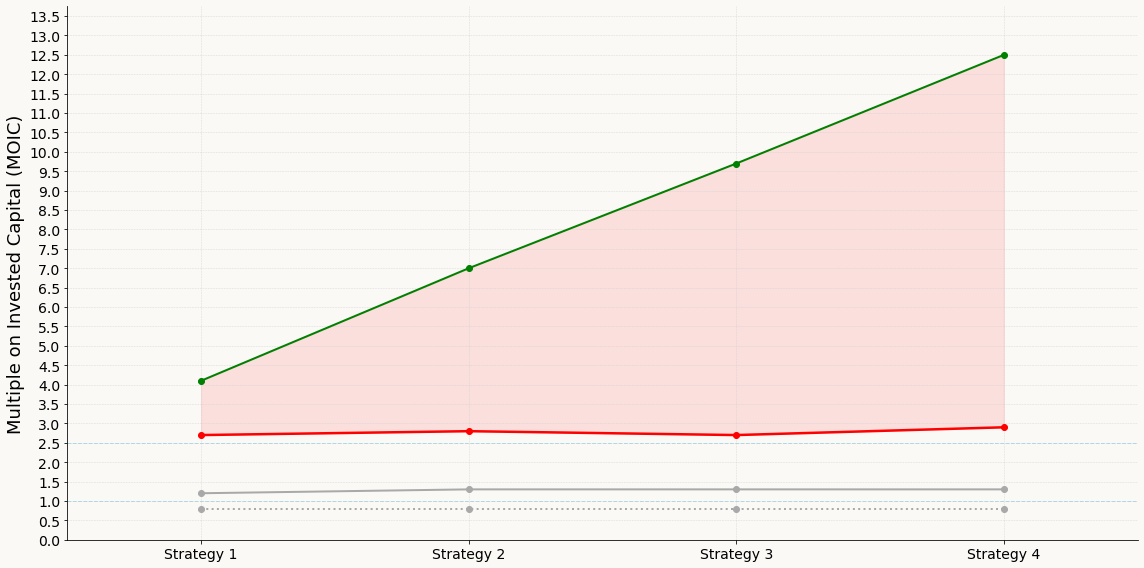


Strategy Details (tab-separated for Excel):
Metric	Strategy 1	Strategy 2	Strategy 3	Strategy 4
Fund Size	$200M	$200M	$200M	$200M
Follow-on Capital Reserved	$60M	$60M	$60M	$60M
Pro-Rata Valuation Threshold	$200M	$200M	$200M	$200M
Initial Pre-seed Check Size	$1.8M	$1.8M	$1.8M	$1.8M
Initial Seed Check Size	$3.5M	$3.5M	$3.5M	$3.5M
Total Pre-seed Capital Deployed	$70M	$70M	$70M	$70M
Total Seed Capital Deployed	$70M	$70M	$70M	$70M
Pre-seed Avg Ownership (initial)	11.67%	11.67%	11.67%	11.67%
Seed Avg Ownership (initial)	11.67%	11.67%	11.67%	11.67%
Overall Ownership (initial)	11.67%	11.67%	11.67%	11.67%
Avg actual portfolio size	60.1	60.1	60.1	60.1
Total # of Portfolio Companies	60	60	60	60
# of Pre-seed Companies (original)	40	40	40	40
# of Seed Companies (original)	20	20	20	20
# of Pre-seed Companies	60,043	59,788	59,991	60,041
# of Seed Companies	60,291	60,007	60,051	60,214
# of Series A Companies	30,145	30,129	30,114	29,932
# of Series B Companies	14,851	15,063	15,018	15,166
# of Series C

In [ ]:


experiment = Experiment()

stage_val_1 = DEFAULT_STAGE_VALUATIONS.copy()
stage_val_2 = DEFAULT_STAGE_VALUATIONS.copy()
stage_val_3 = DEFAULT_STAGE_VALUATIONS.copy()
stage_val_1['Series G'] = 20000
stage_val_2['Series G'] = 30000
stage_val_3['Series G'] = 40000

print(stage_val_1, stage_val_2, stage_val_3)

    # { ## Better M&A
    #     **base_config,
    #     'primary_investments': {'Pre-seed': 70, 'Seed': 70},
    #     'initial_investment_sizes': {'Pre-seed': 1.75, 'Seed': 3.5},
    #     'follow_on_reserve': 60,
    #     'pro_rata_at_or_below': DEFAULT_STAGE_VALUATIONS['Series B']
    # }

config_options = {
    'stages': DEFAULT_STAGES,  
    'graduation_rates': MARKET,
    'stage_dilution': DEFAULT_STAGE_DILUTION,
    'stage_valuations':  [DEFAULT_STAGE_VALUATIONS, stage_val_1, stage_val_2, stage_val_3],
    'lifespan_periods': DEFAULT_LIFESPAN_PERIODS,
    'lifespan_years': DEFAULT_LIFESPAN_YEARS,
    'primary_investments': {'Pre-seed': 70, 'Seed': 70},
    'initial_investment_sizes': {'Pre-seed': 1.75, 'Seed': 3.5},
    'follow_on_reserve': 60,
    'fund_size': 200,
    'pro_rata_at_or_below': DEFAULT_STAGE_VALUATIONS['Series B'],
    'num_scenarios': 3000
}

configurations = experiment.generate_montecarlo_configurations(config_options)
# print(configurations)
montecarlo_results = experiment.simulate_multiple_firm_strategies(configurations)
experiment.visualize_multiple_strategies(montecarlo_results)

In [ ]:
experiment = Experiment()
'''
initial_investment_size_options = [
        {   
            'Pre-seed': 1.5,  
            'Seed': 4
        },
        {   
            'Pre-seed': 1.5,  
            'Seed': 5
        },
        {   
            'Pre-seed':  2,
            'Seed': 4
        },
        {   
            'Pre-seed':  2,
            'Seed': 5
        },
        {   
            'Pre-seed':  2.5,
            'Seed': 4
        },
        {   
            'Pre-seed':  2.5,
            'Seed': 5
        },
        {   
            'Pre-seed':  3,
            'Seed': 4
        },
        {   
            'Pre-seed':  3,
            'Seed': 5
        }
    ]
'''
initial_investment_size_options = [
        {   
            'Pre-seed': 0.5,  
            'Seed': 3
        },
        {   
            'Pre-seed': 0.5,  
            'Seed': 5
        },
        {   
            'Pre-seed':  1,
            'Seed': 3
        },
        {   
            'Pre-seed':  1,
            'Seed': 5
        },
        {   
            'Pre-seed':  1.5,
            'Seed': 3
        },
        {   
            'Pre-seed':  1.5,
            'Seed': 5
        },
        {   
            'Pre-seed':  2,
            'Seed': 3
        },
        {   
            'Pre-seed':  2,
            'Seed': 5
        }
    ]

config_options = {
    'stages': DEFAULT_STAGES,  
    'graduation_rates': [MARKET, ABOVE_MARKET, BELOW_MARKET],
    'stage_dilution': DEFAULT_STAGE_DILUTION,
    'stage_valuations': DEFAULT_STAGE_VALUATIONS,
    'lifespan_periods': DEFAULT_LIFESPAN_PERIODS,
    'lifespan_years': DEFAULT_LIFESPAN_YEARS,
    'primary_investments': {'Pre-seed': 85, 'Seed': 85},
    'initial_investment_sizes': initial_investment_size_options,
    'follow_on_reserve': 30,
    'fund_size': 200,
    'pro_rata_at_or_below': 70,
    'num_scenarios': 3000
}

configurations = experiment.generate_montecarlo_configurations(config_options)
montecarlo_results = experiment.simulate_multiple_firm_strategies(configurations)
experiment.visualize_multiple_strategies(montecarlo_results)

In [ ]:
experiment = Experiment()

fund_size = 200
follow_on_reserve = 30
investable_fund = fund_size - follow_on_reserve

primary_investments_list = [
    {"Pre-seed": 0, "Seed": investable_fund},
    {"Pre-seed": 0.25 * investable_fund, "Seed": 0.75 * investable_fund},
    {"Pre-seed": 0.5 * investable_fund, "Seed": 0.5 * investable_fund},
    {"Pre-seed": 0.75 * investable_fund, "Seed": 0.25 * investable_fund},
    {"Pre-seed": investable_fund, "Seed": 0},
]

config_options = {
    "stages": DEFAULT_STAGES,
    "graduation_rates": [MARKET, ABOVE_MARKET, BELOW_MARKET],
    "stage_dilution": DEFAULT_STAGE_DILUTION,
    "stage_valuations": DEFAULT_STAGE_VALUATIONS,
    "lifespan_periods": DEFAULT_LIFESPAN_PERIODS,
    "lifespan_years": DEFAULT_LIFESPAN_YEARS,
    "primary_investments": primary_investments_list,
    "initial_investment_sizes": {"Pre-seed": 1.5, "Seed": 4.5},
    "follow_on_reserve": follow_on_reserve,
    "fund_size": fund_size,
    "pro_rata_at_or_below": 70,
    "num_scenarios": 3000,
}

configurations = experiment.generate_montecarlo_configurations(config_options)
montecarlo_results = experiment.simulate_multiple_firm_strategies(configurations)
experiment.visualize_multiple_strategies(montecarlo_results)

In [ ]:
experiment = Experiment()

# Define the variations
pro_rata_amounts = [0,30, 60, 100]
follow_on_stages = ['Seed', 'Series A', 'Series B', 'Series C', 'Series D']

# Base configuration
base_config = {
    'stages': DEFAULT_STAGES,
    'graduation_rates': MARKET,
    'stage_dilution': DEFAULT_STAGE_DILUTION,
    'stage_valuations': DEFAULT_STAGE_VALUATIONS,
    'lifespan_periods': DEFAULT_LIFESPAN_PERIODS,
    'lifespan_years': DEFAULT_LIFESPAN_YEARS,
    'initial_investment_sizes': {'Pre-seed': 1.5, 'Seed': 3},
    'fund_size': 200,
    'num_scenarios': 4000
}

# Generate all combinations of pro-rata amounts and follow-on stages
combinations = list(itertools.product(pro_rata_amounts, follow_on_stages))

all_results = []

for pro_rata, stage in combinations:
    config = base_config.copy()
    config['follow_on_reserve'] = pro_rata
    config['pro_rata_at_or_below'] = DEFAULT_STAGE_VALUATIONS[stage]
    
    # Calculate primary investments based on 50/50 split and remaining fund size
    primary_total = 200 - pro_rata
    config['primary_investments'] = {
        'Pre-seed': primary_total * 0.7,
        'Seed': primary_total * 0.3
    }
    
    print(f"Running simulation for Pro-rata: ${pro_rata}M, Follow-on stage: {stage}")
    
    # Generate configuration
    mc_config = experiment.create_montecarlo_sim_configuration(config)
    
    if mc_config:
        # Run simulation
        result = experiment.run_montecarlo(mc_config)
        if result:
            result['Pro-rata Amount'] = pro_rata
            result['Follow-on Stage'] = stage
            result['Fund Composition'] = "Pre-seed: 50%, Seed: 50%"
            all_results.append(result)

# Visualize combined results
experiment.visualize_multiple_strategies(all_results)

In [ ]:
experiment = Experiment()

# Define the specific combinations
combinations = [
    (0, 'Seed'),
    (30, 'Series A'),
    (60, 'Series B'),
    (100, 'Series D')
]

# Base configuration
base_config = {
    'stages': DEFAULT_STAGES,
    'graduation_rates': MARKET,
    'stage_dilution': DEFAULT_STAGE_DILUTION,
    'stage_valuations': DEFAULT_STAGE_VALUATIONS,
    'lifespan_periods': DEFAULT_LIFESPAN_PERIODS,
    'lifespan_years': DEFAULT_LIFESPAN_YEARS,
    'initial_investment_sizes': {'Pre-seed': 1.5, 'Seed': 3},
    'fund_size': 200,
    'num_scenarios': 5000
}

all_results = []

for pro_rata, stage in combinations:
    config = base_config.copy()
    config['follow_on_reserve'] = pro_rata
    config['pro_rata_at_or_below'] = DEFAULT_STAGE_VALUATIONS[stage]
    
    # Calculate primary investments based on 50/50 split and remaining fund size
    primary_total = 200 - pro_rata
    config['primary_investments'] = {
        'Pre-seed': primary_total * 0.5,
        'Seed': primary_total * 0.5
    }
    
    print(f"Running simulation for Pro-rata: ${pro_rata}M, Follow-on stage: {stage}")
    
    # Generate configuration
    mc_config = experiment.create_montecarlo_sim_configuration(config)
    
    if mc_config:
        # Run simulation
        result = experiment.run_montecarlo(mc_config)
        if result:
            result['Pro-rata Amount'] = pro_rata
            result['Follow-on Stage'] = stage
            result['Fund Composition'] = "Pre-seed: 50%, Seed: 50%"
            all_results.append(result)

# Visualize combined results
experiment.visualize_multiple_strategies(all_results)

In [ ]:
experiment = Experiment()

# Define the fund sizes to test
fund_sizes = range(40, 201, 20)

# Base configuration
base_config = {
    'stages': DEFAULT_STAGES,
    'graduation_rates': MARKET,
    'stage_dilution': DEFAULT_STAGE_DILUTION,
    'stage_valuations': DEFAULT_STAGE_VALUATIONS,
    'lifespan_periods': DEFAULT_LIFESPAN_PERIODS,
    'lifespan_years': DEFAULT_LIFESPAN_YEARS,
    'initial_investment_sizes': {'Pre-seed': 1.5},
    'num_scenarios': 3000
}

all_results = []

for fund_size in fund_sizes:
    config = base_config.copy()
    pro_rata = 0.3
    config['fund_size'] = fund_size
    config['primary_investments'] = {'Pre-seed': fund_size*(1-pro_rata)}
    config['follow_on_reserve'] = pro_rata*fund_size
    config['pro_rata_at_or_below'] = 70
    
    print(f"Running simulation for fund size: ${fund_size}M")
    
    # Generate configuration
    mc_config = experiment.create_montecarlo_sim_configuration(config)
    
    if mc_config:
        # Run simulation
        result = experiment.run_montecarlo(mc_config)
        if result:
            result['Fund Size'] = f"${fund_size}M"
            all_results.append(result)

# Visualize combined results
experiment.visualize_multiple_strategies(all_results)

In [ ]:
experiment = Experiment()

# Define the fund sizes to test
fund_sizes = range(40, 301, 20)

# Base configuration
base_config = {
    'stages': DEFAULT_STAGES,
    'graduation_rates': MARKET,
    'stage_dilution': DEFAULT_STAGE_DILUTION,
    'stage_valuations': DEFAULT_STAGE_VALUATIONS,
    'lifespan_periods': DEFAULT_LIFESPAN_PERIODS,
    'lifespan_years': DEFAULT_LIFESPAN_YEARS,
    'initial_investment_sizes': {'Seed': 4.5},
    'num_scenarios': 3000
}

all_results = []

for fund_size in fund_sizes:
    config = base_config.copy()
    config['fund_size'] = fund_size
    pro_rata = 0.3

    config['primary_investments'] = {'Seed': fund_size*(1-pro_rata)}
    config['follow_on_reserve'] = pro_rata*fund_size
    config['pro_rata_at_or_below'] = 70
    
    print(f"Running simulation for fund size: ${fund_size}M")
    
    # Generate configuration
    mc_config = experiment.create_montecarlo_sim_configuration(config)
    
    if mc_config:
        # Run simulation
        result = experiment.run_montecarlo(mc_config)
        if result:
            result['Fund Size'] = f"${fund_size}M"
            all_results.append(result)

# Visualize combined results
experiment.visualize_multiple_strategies(all_results)

In [ ]:
experiment = Experiment()

fund_size = 200
follow_on_reserve = 0
investable_fund = fund_size - follow_on_reserve

primary_investments_list = [
        {   
            'Pre-seed': 0,  
            'Seed': investable_fund       
        },
        {   
            'Pre-seed': 0.25 * investable_fund,  
            'Seed': 0.75 * investable_fund       
        },
        {   
            'Pre-seed': 0.5 * investable_fund,  
            'Seed': 0.5 * investable_fund       
        },
        {   
            'Pre-seed': 0.75 * investable_fund,  
            'Seed': 0.25 * investable_fund       
        },
        {   
            'Pre-seed': investable_fund,
            'Seed': 0
        }
    ]

import copy
better_pre_seed = copy.deepcopy(MARKET)
better_pre_seed['Pre-seed'][0] += 0.1
better_pre_seed['Pre-seed'][1] -= 0.1

config_options = {
    'stages': DEFAULT_STAGES,  
    'graduation_rates': MARKET,
    'stage_dilution': DEFAULT_STAGE_DILUTION,
    'stage_valuations': DEFAULT_STAGE_VALUATIONS,
    'lifespan_periods': DEFAULT_LIFESPAN_PERIODS,
    'lifespan_years': DEFAULT_LIFESPAN_YEARS,
    'primary_investments': primary_investments_list,
    'initial_investment_sizes': {'Pre-seed': 1.5, 'Seed': 3.75},
    'follow_on_reserve': follow_on_reserve,
    'fund_size': fund_size,
    'pro_rata_at_or_below': 200,
    'num_scenarios': 50
}

configurations = experiment.generate_montecarlo_configurations(config_options)
montecarlo_results = experiment.simulate_multiple_firm_strategies(configurations)
experiment.visualize_multiple_strategies(montecarlo_results)

In [ ]:
experiment = Experiment()

initial_investment_size_options = [
        {   
            'Pre-seed': 1.2,  
            'Seed': 1.2*2
        },
        {   
            'Pre-seed': 1.3,  
            'Seed': 1.3*2
        },
        {   
            'Pre-seed':  1.4,
            'Seed': 1.4*2
        },
        {   
            'Pre-seed':  1.5,
            'Seed': 1.5*2
        },
        {   
            'Pre-seed':  1.6,
            'Seed': 1.6*2
        },
        {   
            'Pre-seed':  1.7,
            'Seed': 1.7*2
        },
        {
            'Pre-seed':  1.8,
            'Seed': 1.8*2
        },
        {
            'Pre-seed':  1.9,
            'Seed': 1.9*2
        },
        {
            'Pre-seed':  2.0,
            'Seed': 2.0*2
        }
    ] 

config_options = {
    'stages': DEFAULT_STAGES,  
    'graduation_rates': MARKET,
    'stage_dilution': DEFAULT_STAGE_DILUTION,
    'stage_valuations': DEFAULT_STAGE_VALUATIONS,
    'lifespan_periods': DEFAULT_LIFESPAN_PERIODS,
    'lifespan_years': DEFAULT_LIFESPAN_YEARS,
    'primary_investments': {'Pre-seed': 70, 'Seed': 70},
    'initial_investment_sizes': initial_investment_size_options,
    'follow_on_reserve': 60,
    'fund_size': 200,
    'pro_rata_at_or_below': 200,
    'num_scenarios': 3000
}

configurations = experiment.generate_montecarlo_configurations(config_options)
montecarlo_results = experiment.simulate_multiple_firm_strategies(configurations)
experiment.visualize_multiple_strategies(montecarlo_results)

In [ ]:
experiment = Experiment()

range_strip = [
        {   
            'Pre-seed': .5,  
            'Seed': 6
        },
        {   
            'Pre-seed': .75,  
            'Seed': 5.5
        },
        {   
            'Pre-seed':  1,
            'Seed': 5
        },
        {   
            'Pre-seed':  1.25,
            'Seed': 4.5
        },
        {   
            'Pre-seed':  1.5,
            'Seed': 4
        },
        {   
            'Pre-seed':  1.75,
            'Seed': 3.5
        },
        {   
            'Pre-seed':  2,
            'Seed': 3
        },
        {   
            'Pre-seed':  2.25,
            'Seed': 2.5
        },
        {   
            'Pre-seed':  2.5,
            'Seed': 2
        },
        {   
            'Pre-seed':  2.75,
            'Seed': 1.5
        },
        {   
            'Pre-seed':  3,
            'Seed': 1
        }
    ]


seed_strip = [
        {   
            'Pre-seed': 1.5,  
            'Seed': 2
        },
        {   
            'Pre-seed': 1.5,  
            'Seed': 2.5
        },
        {   
            'Pre-seed':  1.5,
            'Seed': 3
        },
        {   
            'Pre-seed':  1.5,
            'Seed': 3.5
        },
        {   
            'Pre-seed':  1.5,
            'Seed': 4
        },
        {   
            'Pre-seed':  1.5,
            'Seed': 4.5
        },
        {   
            'Pre-seed':  1.5,
            'Seed': 5
        },
                {   
            'Pre-seed':  1.5,
            'Seed': 5.5
        },
        {   
            'Pre-seed':  1.5,
            'Seed': 6
        }
    ]

pre_seed_strip = [
        {   
            'Pre-seed': 0.5,  
            'Seed': 3
        },
        {   
            'Pre-seed': 1,  
            'Seed': 3
        },
        {   
            'Pre-seed':  1.5,
            'Seed': 3
        },
        {   
            'Pre-seed':  2,
            'Seed': 3
        },
        {   
            'Pre-seed':  2.5,
            'Seed': 3
        },
        {   
            'Pre-seed':  3,
            'Seed': 3
        }
    ]


seed_strip_short = [
        {   
            'Pre-seed': 1.5,  
            'Seed': 1.5
        },
        {   
            'Pre-seed':  1.5,
            'Seed': 3
        },
        {   
            'Pre-seed':  1.5,
            'Seed': 4.5
        },
        {   
            'Pre-seed':  1.5,
            'Seed': 6
        }
    ]

pre_seed_strip_short = [
        {   
            'Pre-seed': 0.5,  
            'Seed': 3
        },
        {   
            'Pre-seed': 1,  
            'Seed': 3
        },
        {   
            'Pre-seed':  1.5,
            'Seed': 3
        },
        {   
            'Pre-seed':  2,
            'Seed': 3
        }
    ]

config_options = {
    'stages': DEFAULT_STAGES,  
    'graduation_rates': MARKET,
    'stage_dilution': DEFAULT_STAGE_DILUTION,
    'stage_valuations': DEFAULT_STAGE_VALUATIONS,
    'lifespan_periods': DEFAULT_LIFESPAN_PERIODS,
    'lifespan_years': DEFAULT_LIFESPAN_YEARS,
    'primary_investments': {'Pre-seed': 70, 'Seed': 70},
    'initial_investment_sizes': range_strip,
    'follow_on_reserve': 60,
    'fund_size': 200,
    'pro_rata_at_or_below': 70,
    'num_scenarios': 5000
}

configurations = experiment.generate_montecarlo_configurations(config_options)
montecarlo_results = experiment.simulate_multiple_firm_strategies(configurations)
experiment.visualize_multiple_strategies(montecarlo_results)

In [ ]:

import copy

MARKET = {
    'Pre-seed':    [0.50, 0.35, 0.15],
    'Seed':        [0.50, 0.35, 0.15],
    'Series A':    [0.50, 0.30, 0.20],
    'Series B':    [0.50, 0.25, 0.25],
    'Series C':    [0.50, 0.25, 0.25],
    'Series D':    [0.50, 0.25, 0.25],
    'Series E':    [0.40, 0.30, 0.30],
    'Series F':    [0.30, 0.30, 0.30],
    'Series G':    ['X', 'X', 'X']  
}

better_m_and_a_stages = ['Pre-seed', 'Seed', 'Series A', 'Series B']

five_pp_better_m_and_a = copy.deepcopy(MARKET)

for stage, rates in five_pp_better_m_and_a.items():
    if stage in better_m_and_a_stages:
        rates[2] += 0.05
        rates[1] -= 0.05
        five_pp_better_m_and_a[stage] = [round(rate, 2) for rate in rates]

ten_pp_better_m_and_a = copy.deepcopy(MARKET)

for stage, rates in ten_pp_better_m_and_a.items():
    if stage in better_m_and_a_stages:
        rates[2] += 0.1
        rates[1] -= 0.1
        ten_pp_better_m_and_a[stage] = [round(rate, 2) for rate in rates]

print('------------')
print('Market', MARKET)
print('5pp', five_pp_better_m_and_a)
print('10pp', ten_pp_better_m_and_a)

experiment = Experiment()

config_options = {
    'stages': DEFAULT_STAGES,  
    'graduation_rates': [MARKET, five_pp_better_m_and_a, ten_pp_better_m_and_a],
    'stage_dilution': DEFAULT_STAGE_DILUTION,
    'stage_valuations': DEFAULT_STAGE_VALUATIONS,
    'lifespan_periods': DEFAULT_LIFESPAN_PERIODS,
    'lifespan_years': DEFAULT_LIFESPAN_YEARS,
    'primary_investments': {'Pre-seed': 70, 'Seed': 70},
    'initial_investment_sizes': {'Pre-seed': 1.5, 'Seed': 4.5},
    'follow_on_reserve': 60,
    'fund_size': 200,
    'pro_rata_at_or_below': 70,
    'num_scenarios': 3000
}

configurations = experiment.generate_montecarlo_configurations(config_options)
montecarlo_results = experiment.simulate_multiple_firm_strategies(configurations)
experiment.visualize_multiple_strategies(montecarlo_results)

In [ ]:

import copy

MARKET = {
    'Pre-seed':    [0.50, 0.35, 0.15],
    'Seed':        [0.50, 0.35, 0.15],
    'Series A':    [0.50, 0.30, 0.20],
    'Series B':    [0.50, 0.25, 0.25],
    'Series C':    [0.50, 0.25, 0.25],
    'Series D':    [0.50, 0.25, 0.25],
    'Series E':    [0.40, 0.30, 0.30],
    'Series F':    [0.30, 0.30, 0.30],
    'Series G':    ['X', 'X', 'X']  
}

better_m_and_a_stages = ['Pre-seed', 'Seed', 'Series A', 'Series B']
better_picking_stages = ['Pre-seed']

better_picker = copy.deepcopy(MARKET)

for stage, rates in better_picker.items():
    if stage in better_picking_stages:
        rates[0] += 0.1
        rates[1] -= 0.1
        better_picker[stage] = [round(rate, 2) for rate in rates]

better_picker_and_seller = copy.deepcopy(better_picker)

for stage, rates in better_picker_and_seller.items():
    if stage in better_m_and_a_stages:
        rates[2] += 0.1
        rates[1] -= 0.1
        better_picker_and_seller[stage] = [round(rate, 2) for rate in rates]

print('------------')
print('Market', MARKET)
print('better picker', better_picker)
print('better picker & seller', better_picker_and_seller)

experiment = Experiment()

config_options = {
    'stages': DEFAULT_STAGES,  
    'graduation_rates': [MARKET, better_picker, better_picker_and_seller],
    'stage_dilution': DEFAULT_STAGE_DILUTION,
    'stage_valuations': DEFAULT_STAGE_VALUATIONS,
    'lifespan_periods': DEFAULT_LIFESPAN_PERIODS,
    'lifespan_years': DEFAULT_LIFESPAN_YEARS,
    'primary_investments': {'Pre-seed': 70, 'Seed': 70},
    'initial_investment_sizes': {'Pre-seed': 1.5, 'Seed': 3},
    'follow_on_reserve': 60,
    'fund_size': 200,
    'pro_rata_at_or_below': 70,
    'num_scenarios': 5000
}

# configurations = experiment.generate_montecarlo_configurations(config_options)
# montecarlo_results = experiment.simulate_multiple_firm_strategies(configurations)
# experiment.visualize_multiple_strategies(montecarlo_results)

------------
Market {'Pre-seed': [0.5, 0.35, 0.15], 'Seed': [0.5, 0.35, 0.15], 'Series A': [0.5, 0.3, 0.2], 'Series B': [0.5, 0.25, 0.25], 'Series C': [0.5, 0.25, 0.25], 'Series D': [0.5, 0.25, 0.25], 'Series E': [0.4, 0.3, 0.3], 'Series F': [0.3, 0.3, 0.3], 'Series G': ['X', 'X', 'X']}
better picker {'Pre-seed': [0.6, 0.25, 0.15], 'Seed': [0.5, 0.35, 0.15], 'Series A': [0.5, 0.3, 0.2], 'Series B': [0.5, 0.25, 0.25], 'Series C': [0.5, 0.25, 0.25], 'Series D': [0.5, 0.25, 0.25], 'Series E': [0.4, 0.3, 0.3], 'Series F': [0.3, 0.3, 0.3], 'Series G': ['X', 'X', 'X']}
better picker & seller {'Pre-seed': [0.6, 0.15, 0.25], 'Seed': [0.5, 0.25, 0.25], 'Series A': [0.5, 0.2, 0.3], 'Series B': [0.5, 0.15, 0.35], 'Series C': [0.5, 0.25, 0.25], 'Series D': [0.5, 0.25, 0.25], 'Series E': [0.4, 0.3, 0.3], 'Series F': [0.3, 0.3, 0.3], 'Series G': ['X', 'X', 'X']}


In [ ]:
# Base configuration

base_config = {
    'stages': DEFAULT_STAGES,
    'graduation_rates': MARKET,
    'stage_dilution': DEFAULT_STAGE_DILUTION,
    'stage_valuations': DEFAULT_STAGE_VALUATIONS,
    'lifespan_periods': DEFAULT_LIFESPAN_PERIODS,
    'lifespan_years': DEFAULT_LIFESPAN_YEARS,
    'fund_size': 200,
    'num_scenarios': 5000
}

configs = [
    # { ## Pre-seed spray and pray
    #     **base_config,
    #     'primary_investments': {'Pre-seed': 100},
    #     'initial_investment_sizes': {'Pre-seed': 1.5},
    #     'follow_on_reserve': 100,
    #     'pro_rata_at_or_below': DEFAULT_STAGE_VALUATIONS['Series D']
    # },
    # { ## 50/50 pre-seed / seed split
    #     **base_config,
    #     'primary_investments': {'Pre-seed': 50, 'Seed':50},
    #     'initial_investment_sizes': {'Pre-seed': 1.5, 'Seed':3},
    #     'follow_on_reserve': 100,
    #     'pro_rata_at_or_below': DEFAULT_STAGE_VALUATIONS['Series D']
    # },
    # { ## Smarter pro rata 
    #     **base_config,
    #     'primary_investments': {'Pre-seed': 70, 'Seed': 70},
    #     'initial_investment_sizes': {'Pre-seed': 1.5, 'Seed': 3},
    #     'follow_on_reserve': 60,
    #     'pro_rata_at_or_below': DEFAULT_STAGE_VALUATIONS['Series B']
    # },
    # { ## Better picker
    #     **base_config,
    #     'primary_investments': {'Pre-seed': 70, 'Seed': 70},
    #     'initial_investment_sizes': {'Pre-seed': 1.5, 'Seed': 3},
    #     'follow_on_reserve': 60,
    #     'pro_rata_at_or_below': DEFAULT_STAGE_VALUATIONS['Series B']
    # },
    # { ## Better M&A
    #     **base_config,
    #     'primary_investments': {'Pre-seed': 70, 'Seed': 70},
    #     'initial_investment_sizes': {'Pre-seed': 1.5, 'Seed': 3},
    #     'follow_on_reserve': 60,
    #     'pro_rata_at_or_below': DEFAULT_STAGE_VALUATIONS['Series B']
    # }
    { ## Pre-seed spray and pray
        **base_config,
        'primary_investments': {'Pre-seed': 100},
        'initial_investment_sizes': {'Pre-seed': 1.75},
        'follow_on_reserve': 100,
        'pro_rata_at_or_below': DEFAULT_STAGE_VALUATIONS['Series D']
    },
    { ## 50/50 pre-seed / seed split
        **base_config,
        'primary_investments': {'Pre-seed': 50, 'Seed':50},
        'initial_investment_sizes': {'Pre-seed': 1.75, 'Seed':3.5},
        'follow_on_reserve': 100,
        'pro_rata_at_or_below': DEFAULT_STAGE_VALUATIONS['Series D']
    },
    { ## Smarter pro rata 
        **base_config,
        'primary_investments': {'Pre-seed': 70, 'Seed': 70},
        'initial_investment_sizes': {'Pre-seed': 1.75, 'Seed': 3.5},
        'follow_on_reserve': 60,
        'pro_rata_at_or_below': DEFAULT_STAGE_VALUATIONS['Series B']
    },
    { ## Better picker
        **base_config,
        'primary_investments': {'Pre-seed': 70, 'Seed': 70},
        'initial_investment_sizes': {'Pre-seed': 1.75, 'Seed': 3.5},
        'follow_on_reserve': 60,
        'pro_rata_at_or_below': DEFAULT_STAGE_VALUATIONS['Series B']
    },
    { ## Better M&A
        **base_config,
        'primary_investments': {'Pre-seed': 70, 'Seed': 70},
        'initial_investment_sizes': {'Pre-seed': 1.75, 'Seed': 3.5},
        'follow_on_reserve': 60,
        'pro_rata_at_or_below': DEFAULT_STAGE_VALUATIONS['Series B']
    }, 
        { ## Better series G valuation
        **base_config,
        'primary_investments': {'Pre-seed': 70, 'Seed': 70},
        'initial_investment_sizes': {'Pre-seed': 1.75, 'Seed': 3.5},
        'follow_on_reserve': 60,
        'pro_rata_at_or_below': DEFAULT_STAGE_VALUATIONS['Series B']
    }
]

configs[-3]['graduation_rates'] = better_picker
configs[-2]['graduation_rates'] = better_picker_and_seller
configs[-1]['graduation_rates'] = better_picker_and_seller
configs[-1]['stage_valuations'] = STAGE_VALUATIONS_OUTSIZED_SERIES_G
## configs[-2]['graduation_rates'] = better_picker_and_seller

print(configs)
for c in configs:
    print(c)
    print('---------')

# Create Experiment instance
experiment = Experiment()

# Run simulations for each configuration
all_results = []
for i, config in enumerate(configs, 1):
    print(f"Running simulation for Strategy {i}")
    mc_config = experiment.create_montecarlo_sim_configuration(config)
    if mc_config:
        result = experiment.run_montecarlo(mc_config)
        if result:
            result['Strategy'] = f'Strategy {i}'
            all_results.append(result)

# Visualize combined results
experiment.visualize_multiple_strategies(all_results)

[{'stages': ['Pre-seed', 'Seed', 'Series A', 'Series B', 'Series C', 'Series D', 'Series E', 'Series F', 'Series G'], 'graduation_rates': {'Pre-seed': [0.5, 0.35, 0.15], 'Seed': [0.5, 0.35, 0.15], 'Series A': [0.5, 0.3, 0.2], 'Series B': [0.5, 0.25, 0.25], 'Series C': [0.5, 0.25, 0.25], 'Series D': [0.5, 0.25, 0.25], 'Series E': [0.4, 0.3, 0.3], 'Series F': [0.3, 0.3, 0.3], 'Series G': ['X', 'X', 'X']}, 'stage_dilution': {'Seed': 0.2, 'Series A': 0.22, 'Series B': 0.2, 'Series C': 0.15, 'Series D': 0.1, 'Series E': 0.08, 'Series F': 0.08, 'Series G': 0.08}, 'stage_valuations': {'Pre-seed': 15, 'Seed': 30, 'Series A': 70, 'Series B': 200, 'Series C': 500, 'Series D': 750, 'Series E': 1500, 'Series F': 5000, 'Series G': 10000}, 'lifespan_periods': 8, 'lifespan_years': 13, 'fund_size': 200, 'num_scenarios': 5000, 'primary_investments': {'Pre-seed': 100}, 'initial_investment_sizes': {'Pre-seed': 1.75}, 'follow_on_reserve': 100, 'pro_rata_at_or_below': 750}, {'stages': ['Pre-seed', 'Seed', 

In [ ]:
experiment = Experiment()

initial_investment_size_options = [
        {   
            'Pre-seed': .5,  
            'Seed': 1
        },
        {   
            'Pre-seed': 1,  
            'Seed': 2
        },
        {   
            'Pre-seed':  1.5,
            'Seed': 3
        },
        {   
            'Pre-seed':  2,
            'Seed': 4
        },
        {   
            'Pre-seed':  2.5,
            'Seed': 5
        },
        {   
            'Pre-seed':  3,
            'Seed': 6
        }
    ]

config_options = {
    'stages': DEFAULT_STAGES,  
    'graduation_rates': MARKET,
    'stage_dilution': DEFAULT_STAGE_DILUTION,
    'stage_valuations': DEFAULT_STAGE_VALUATIONS,
    'lifespan_periods': DEFAULT_LIFESPAN_PERIODS,
    'lifespan_years': DEFAULT_LIFESPAN_YEARS,
    'primary_investments': {'Seed': 250},
    'initial_investment_sizes': initial_investment_size_options,
    'follow_on_reserve': 250,
    'fund_size': 500,
    'pro_rata_at_or_below': 200,
    'num_scenarios': 3000
}

configurations = experiment.generate_montecarlo_configurations(config_options)
montecarlo_results = experiment.simulate_multiple_firm_strategies(configurations)
experiment.visualize_multiple_strategies(montecarlo_results)

In [ ]:
experiment = Experiment()

target_portfolio_options = [
        {   
            'Pre-seed': 1,  
            'Seed': 2
        },
        {   
            'Pre-seed': 1.25,  
            'Seed': 2.5
        },
        {   
            'Pre-seed':  1.5,
            'Seed': 3
        },
        {   
            'Pre-seed':  1.75,
            'Seed': 3.5
        },
        {   
            'Pre-seed':  2,
            'Seed': 4
        },
        {   
            'Pre-seed':  2.25,
            'Seed': 4.5
        },
        {   
            'Pre-seed':  2.5,
            'Seed': 5
        }
    ] 

config_options = {
    'stages': DEFAULT_STAGES,  
    'graduation_rates': MARKET,
    'stage_dilution': DEFAULT_STAGE_DILUTION,
    'stage_valuations': DEFAULT_STAGE_VALUATIONS,
    'lifespan_periods': DEFAULT_LIFESPAN_PERIODS,
    'lifespan_years': DEFAULT_LIFESPAN_YEARS,
    'primary_investments': {'Pre-seed': 70, 'Seed': 70},
    'initial_investment_sizes': target_portfolio_options,
    'follow_on_reserve': 60,
    'fund_size': 200,
    'pro_rata_at_or_below': 200,
    'num_scenarios': 3000
}

configurations = experiment.generate_montecarlo_configurations(config_options)
montecarlo_results = experiment.simulate_multiple_firm_strategies(configurations)
experiment.visualize_multiple_strategies(montecarlo_results)

In [ ]:
experiment = Experiment()

target_portfolio_options = [
        {   
            'Pre-seed': 1,  
            'Seed': 2
        },
        {   
            'Pre-seed': 1.25,  
            'Seed': 2.5
        },
        {   
            'Pre-seed':  1.5,
            'Seed': 3
        },
        {   
            'Pre-seed':  1.75,
            'Seed': 3.5
        },
        {   
            'Pre-seed':  2,
            'Seed': 4
        },
        {   
            'Pre-seed':  2.25,
            'Seed': 4.5
        },
        {   
            'Pre-seed':  2.5,
            'Seed': 5
        },
        {   
            'Pre-seed':  2.75,
            'Seed': 5.5
        },
        {   
            'Pre-seed':  3,
            'Seed': 6
        }
    ] 

config_options = {
    'stages': DEFAULT_STAGES,  
    'graduation_rates': MARKET,
    'stage_dilution': DEFAULT_STAGE_DILUTION,
    'stage_valuations': DEFAULT_STAGE_VALUATIONS,
    'lifespan_periods': DEFAULT_LIFESPAN_PERIODS,
    'lifespan_years': DEFAULT_LIFESPAN_YEARS,
    'primary_investments': {'Pre-seed': 70, 'Seed': 70},
    'initial_investment_sizes': target_portfolio_options,
    'follow_on_reserve': 60,
    'fund_size': 200,
    'pro_rata_at_or_below': 200,
    'num_scenarios': 5000
}

configurations = experiment.generate_montecarlo_configurations(config_options)
montecarlo_results = experiment.simulate_multiple_firm_strategies(configurations)
experiment.visualize_multiple_strategies(montecarlo_results)

In [ ]:
experiment = Experiment()

fund_size = 200
follow_on_reserve = 60
investable_fund = fund_size - follow_on_reserve

primary_investments_list = [
        {   
            'Pre-seed': 0,  
            'Seed': investable_fund       
        },
        {   
            'Pre-seed': 0.25 * investable_fund,  
            'Seed': 0.75 * investable_fund       
        },
        {   
            'Pre-seed': 0.5 * investable_fund,  
            'Seed': 0.5 * investable_fund       
        },
        {   
            'Pre-seed': 0.75 * investable_fund,  
            'Seed': 0.25 * investable_fund       
        },        
        {   
            'Pre-seed': investable_fund,
            'Seed': 0
        }
    ]

config_options = {
    'stages': DEFAULT_STAGES,  
    'graduation_rates': MARKET,
    'stage_dilution': DEFAULT_STAGE_DILUTION,
    'stage_valuations': DEFAULT_STAGE_VALUATIONS,
    'lifespan_periods': DEFAULT_LIFESPAN_PERIODS,
    'lifespan_years': DEFAULT_LIFESPAN_YEARS,
    'primary_investments': primary_investments_list,
    'initial_investment_sizes': {'Pre-seed': 1.75, 'Seed': 3.5},
    'follow_on_reserve': follow_on_reserve,
    'fund_size': fund_size,
    'pro_rata_at_or_below': 200,
    'num_scenarios': 8000
}

configurations = experiment.generate_montecarlo_configurations(config_options)
montecarlo_results = experiment.simulate_multiple_firm_strategies(configurations)
experiment.visualize_multiple_strategies(montecarlo_results)

In [ ]:
 experiment = Experiment()

# Define the specific combinations
combinations = [
    (0, 'Seed'),
    (30, 'Series A'),
    (60, 'Series B'),
    (100, 'Series D')
]

# Base configuration
base_config = {
    'stages': DEFAULT_STAGES,
    'graduation_rates': MARKET,
    'stage_dilution': DEFAULT_STAGE_DILUTION,
    'stage_valuations': DEFAULT_STAGE_VALUATIONS,
    'lifespan_periods': DEFAULT_LIFESPAN_PERIODS,
    'lifespan_years': DEFAULT_LIFESPAN_YEARS,
    'initial_investment_sizes': {'Pre-seed': 1.75, 'Seed': 3.5},
    'fund_size': 200,
    'num_scenarios': 5000
}

all_results = []

for pro_rata, stage in combinations:
    config = base_config.copy()
    config['follow_on_reserve'] = pro_rata
    config['pro_rata_at_or_below'] = DEFAULT_STAGE_VALUATIONS[stage]
    
    # Calculate primary investments based on 50/50 split and remaining fund size
    primary_total = 200 - pro_rata
    config['primary_investments'] = {
        'Pre-seed': primary_total * 0.5,
        'Seed': primary_total * 0.5
    }
    
    print(f"Running simulation for Pro-rata: ${pro_rata}M, Follow-on stage: {stage}")
    
    # Generate configuration
    mc_config = experiment.create_montecarlo_sim_configuration(config)
    
    if mc_config:
        # Run simulation
        result = experiment.run_montecarlo(mc_config)
        if result:
            result['Pro-rata Amount'] = pro_rata
            result['Follow-on Stage'] = stage
            result['Fund Composition'] = "Pre-seed: 50%, Seed: 50%"
            all_results.append(result)

# Visualize combined results
experiment.visualize_multiple_strategies(all_results)

------------
Market {'Pre-seed': [0.5, 0.35, 0.15], 'Seed': [0.5, 0.35, 0.15], 'Series A': [0.5, 0.3, 0.2], 'Series B': [0.5, 0.25, 0.25], 'Series C': [0.5, 0.25, 0.25], 'Series D': [0.5, 0.25, 0.25], 'Series E': [0.4, 0.3, 0.3], 'Series F': [0.3, 0.3, 0.3], 'Series G': ['X', 'X', 'X']}
better picker {'Pre-seed': [0.6, 0.25, 0.15], 'Seed': [0.5, 0.35, 0.15], 'Series A': [0.5, 0.3, 0.2], 'Series B': [0.5, 0.25, 0.25], 'Series C': [0.5, 0.25, 0.25], 'Series D': [0.5, 0.25, 0.25], 'Series E': [0.4, 0.3, 0.3], 'Series F': [0.3, 0.3, 0.3], 'Series G': ['X', 'X', 'X']}
better picker & seller {'Pre-seed': [0.6, 0.15, 0.25], 'Seed': [0.5, 0.25, 0.25], 'Series A': [0.5, 0.2, 0.3], 'Series B': [0.5, 0.15, 0.35], 'Series C': [0.5, 0.25, 0.25], 'Series D': [0.5, 0.25, 0.25], 'Series E': [0.4, 0.3, 0.3], 'Series F': [0.3, 0.3, 0.3], 'Series G': ['X', 'X', 'X']}
Simulating Strategy 1
Simulating Strategy 2
Simulating Strategy 3


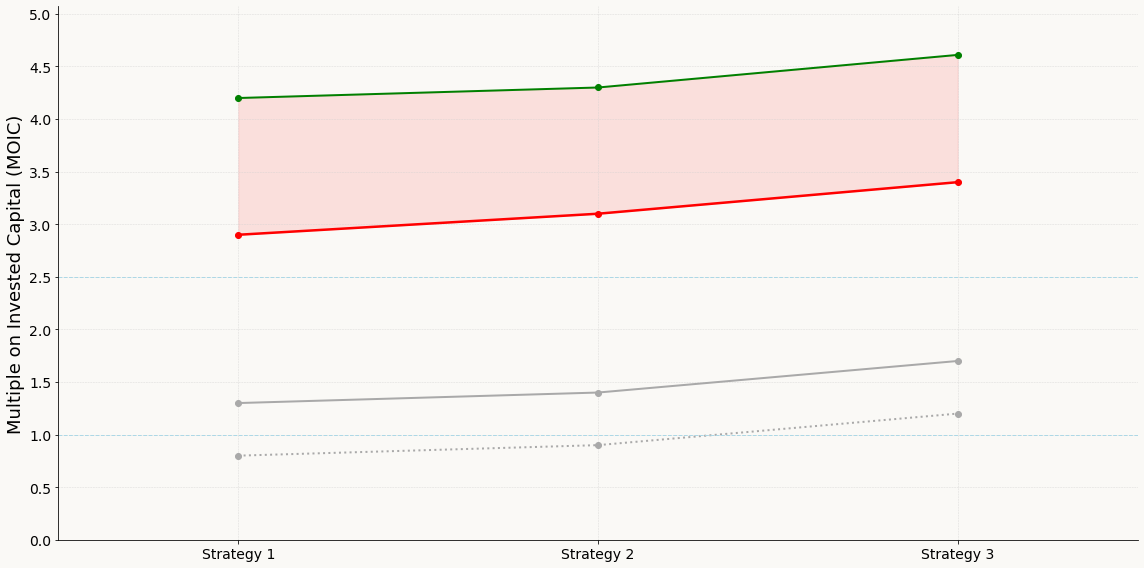


Strategy Details (tab-separated for Excel):
Metric	Strategy 1	Strategy 2	Strategy 3
Fund Size	$200M	$200M	$200M
Follow-on Capital Reserved	$60M	$60M	$60M
Pro-Rata Valuation Threshold	$200M	$200M	$200M
Initial Pre-seed Check Size	$1.8M	$1.8M	$1.8M
Initial Seed Check Size	$3.5M	$3.5M	$3.5M
Total Pre-seed Capital Deployed	$70M	$70M	$70M
Total Seed Capital Deployed	$70M	$70M	$70M
Pre-seed Avg Ownership (initial)	11.67%	11.67%	11.67%
Seed Avg Ownership (initial)	11.67%	11.67%	11.67%
Overall Ownership (initial)	11.67%	11.67%	11.67%
Avg actual portfolio size	60.1	60.0	60.0
Total # of Portfolio Companies	60	60	60
# of Pre-seed Companies (original)	40	40	40
# of Seed Companies (original)	20	20	20
# of Pre-seed Companies	100,112	80,003	79,907
# of Seed Companies	99,900	109,739	109,646
# of Series A Companies	49,905	55,310	55,066
# of Series B Companies	25,251	27,681	27,757
# of Series C Companies	12,446	13,761	13,846
# of Series D Companies	6,397	6,782	6,967
# of Series E Companies	3,726	4,074	

In [ ]:

import copy

better_m_and_a_stages = ['Pre-seed', 'Seed', 'Series A', 'Series B']
better_picking_stages = ['Pre-seed']

better_picker = copy.deepcopy(MARKET)

for stage, rates in better_picker.items():
    if stage in better_picking_stages:
        rates[0] += 0.1
        rates[1] -= 0.1
        better_picker[stage] = [round(rate, 2) for rate in rates]

better_picker_and_seller = copy.deepcopy(better_picker)

for stage, rates in better_picker_and_seller.items():
    if stage in better_m_and_a_stages:
        rates[2] += 0.1
        rates[1] -= 0.1
        better_picker_and_seller[stage] = [round(rate, 2) for rate in rates]

print('------------')
print('Market', MARKET)
print('better picker', better_picker)
print('better picker & seller', better_picker_and_seller)

experiment = Experiment()

config_options = {
    'stages': DEFAULT_STAGES,  
    'graduation_rates': [MARKET, better_picker, better_picker_and_seller],
    'stage_dilution': DEFAULT_STAGE_DILUTION,
    'stage_valuations': DEFAULT_STAGE_VALUATIONS,
    'lifespan_periods': DEFAULT_LIFESPAN_PERIODS,
    'lifespan_years': DEFAULT_LIFESPAN_YEARS,
    'primary_investments': {'Pre-seed': 70, 'Seed': 70},
    'initial_investment_sizes': {'Pre-seed': 1.75, 'Seed': 3.5},
    'follow_on_reserve': 60,
    'fund_size': 200,
    'pro_rata_at_or_below': 200,
    'num_scenarios': 5000
}

configurations = experiment.generate_montecarlo_configurations(config_options)
montecarlo_results = experiment.simulate_multiple_firm_strategies(configurations)
experiment.visualize_multiple_strategies(montecarlo_results)

In [ ]:
experiment = Experiment()

config_options = {
    'stages': DEFAULT_STAGES,
    'graduation_rates': MARKET,
    'stage_dilution': DEFAULT_STAGE_DILUTION,
    'stage_valuations': DEFAULT_STAGE_VALUATIONS,
    'lifespan_periods': DEFAULT_LIFESPAN_PERIODS,
    'lifespan_years': DEFAULT_LIFESPAN_YEARS,
    'primary_investments': {'Pre-seed': 100},
    'initial_investment_sizes': {'Pre-seed': 1.75},
    'follow_on_reserve': 100,
    'fund_size': 200,
    'pro_rata_at_or_below': 1000,
    'num_scenarios': 20000
}

# Create the Montecarlo_Sim_Configuration object
config = Montecarlo_Sim_Configuration(**config_options)

# Run the simulation and visualize results
experiment.run_single_simulation_and_visualize(config)

------------
Market {'Pre-seed': [0.5, 0.35, 0.15], 'Seed': [0.5, 0.35, 0.15], 'Series A': [0.5, 0.3, 0.2], 'Series B': [0.5, 0.25, 0.25], 'Series C': [0.5, 0.25, 0.25], 'Series D': [0.5, 0.25, 0.25], 'Series E': [0.4, 0.3, 0.3], 'Series F': [0.3, 0.3, 0.3], 'Series G': ['X', 'X', 'X']}
better picker {'Pre-seed': [0.6, 0.25, 0.15], 'Seed': [0.5, 0.35, 0.15], 'Series A': [0.5, 0.3, 0.2], 'Series B': [0.5, 0.25, 0.25], 'Series C': [0.5, 0.25, 0.25], 'Series D': [0.5, 0.25, 0.25], 'Series E': [0.4, 0.3, 0.3], 'Series F': [0.3, 0.3, 0.3], 'Series G': ['X', 'X', 'X']}
better picker & seller {'Pre-seed': [0.6, 0.15, 0.25], 'Seed': [0.5, 0.25, 0.25], 'Series A': [0.5, 0.2, 0.3], 'Series B': [0.5, 0.15, 0.35], 'Series C': [0.5, 0.25, 0.25], 'Series D': [0.5, 0.25, 0.25], 'Series E': [0.4, 0.3, 0.3], 'Series F': [0.3, 0.3, 0.3], 'Series G': ['X', 'X', 'X']}
[{'stages': ['Pre-seed', 'Seed', 'Series A', 'Series B', 'Series C', 'Series D', 'Series E', 'Series F', 'Series G'], 'graduation_rates': {

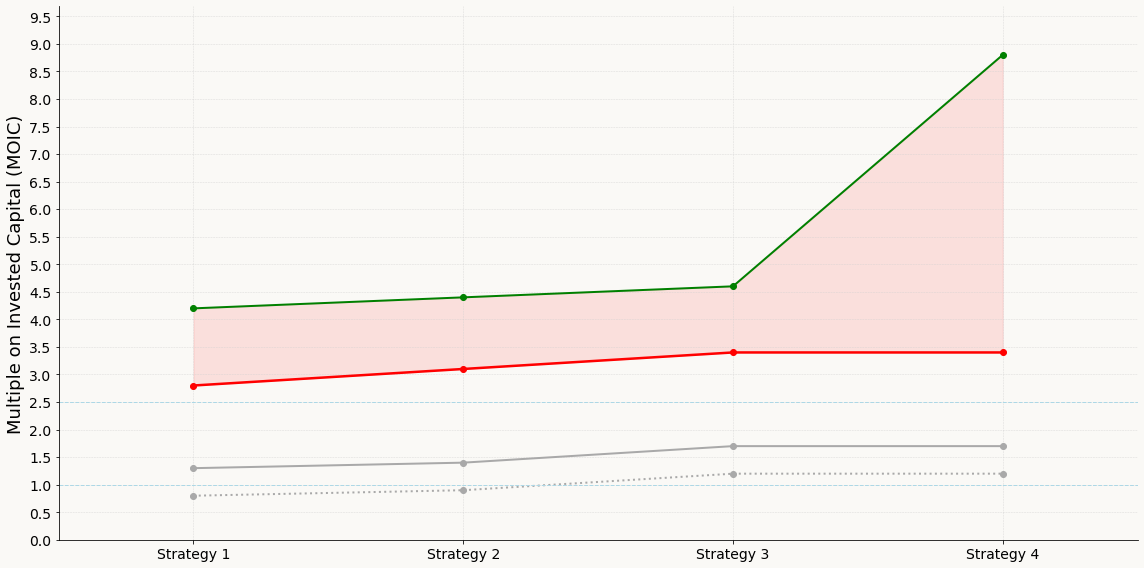


Strategy Details (tab-separated for Excel):
Metric	Strategy 1	Strategy 2	Strategy 3	Strategy 4
Fund Size	$200M	$200M	$200M	$200M
Follow-on Capital Reserved	$60M	$60M	$60M	$60M
Pro-Rata Valuation Threshold	$200M	$200M	$200M	$200M
Initial Pre-seed Check Size	$1.8M	$1.8M	$1.8M	$1.8M
Initial Seed Check Size	$3.5M	$3.5M	$3.5M	$3.5M
Total Pre-seed Capital Deployed	$70M	$70M	$70M	$70M
Total Seed Capital Deployed	$70M	$70M	$70M	$70M
Pre-seed Avg Ownership (initial)	11.67%	11.67%	11.67%	11.67%
Seed Avg Ownership (initial)	11.67%	11.67%	11.67%	11.67%
Overall Ownership (initial)	11.67%	11.67%	11.67%	11.67%
Avg actual portfolio size	60.1	60.0	60.0	60.0
Total # of Portfolio Companies	60	60	60	60
# of Pre-seed Companies (original)	40	40	40	40
# of Seed Companies (original)	20	20	20	20
# of Pre-seed Companies	100,283	79,876	80,229	80,095
# of Seed Companies	99,947	109,933	109,847	109,863
# of Series A Companies	50,078	55,175	54,887	54,973
# of Series B Companies	25,054	27,438	27,460	27,362
# of Seri

In [ ]:
import copy

better_m_and_a_stages = ['Pre-seed', 'Seed', 'Series A', 'Series B']
better_picking_stages = ['Pre-seed']

better_picker = copy.deepcopy(MARKET)

for stage, rates in better_picker.items():
    if stage in better_picking_stages:
        rates[0] += 0.1
        rates[1] -= 0.1
        better_picker[stage] = [round(rate, 2) for rate in rates]

better_picker_and_seller = copy.deepcopy(better_picker)

for stage, rates in better_picker_and_seller.items():
    if stage in better_m_and_a_stages:
        rates[2] += 0.1
        rates[1] -= 0.1
        better_picker_and_seller[stage] = [round(rate, 2) for rate in rates]

print('------------')
print('Market', MARKET)
print('better picker', better_picker)
print('better picker & seller', better_picker_and_seller)

# experiment = Experiment()

# config_options = {
#     'stages': DEFAULT_STAGES,  
#     'graduation_rates': [MARKET, better_picker, better_picker_and_seller],
#     'stage_dilution': DEFAULT_STAGE_DILUTION,
#     'stage_valuations': DEFAULT_STAGE_VALUATIONS,
#     'lifespan_periods': DEFAULT_LIFESPAN_PERIODS,
#     'lifespan_years': DEFAULT_LIFESPAN_YEARS,
#     'primary_investments': {'Pre-seed': 70, 'Seed': 70},
#     'initial_investment_sizes': {'Pre-seed': 1.75, 'Seed': 3.5},
#     'follow_on_reserve': 60,
#     'fund_size': 200,
#     'pro_rata_at_or_below': 200,
#     'num_scenarios': 5000
# }




# Base configuration

base_config = {
    'stages': DEFAULT_STAGES,
    'graduation_rates': MARKET,
    'stage_dilution': DEFAULT_STAGE_DILUTION,
    'stage_valuations': DEFAULT_STAGE_VALUATIONS,
    'lifespan_periods': DEFAULT_LIFESPAN_PERIODS,
    'lifespan_years': DEFAULT_LIFESPAN_YEARS,
    'fund_size': 200,
    'num_scenarios': 5000
}

configs = [
    { ## Better series G valuation
        **base_config,
        'primary_investments': {'Pre-seed': 70, 'Seed': 70},
        'initial_investment_sizes': {'Pre-seed': 1.75, 'Seed': 3.5},
        'follow_on_reserve': 60,
        'pro_rata_at_or_below': DEFAULT_STAGE_VALUATIONS['Series B']
    },
    { ## Better series G valuation
        **base_config,
        'primary_investments': {'Pre-seed': 70, 'Seed': 70},
        'initial_investment_sizes': {'Pre-seed': 1.75, 'Seed': 3.5},
        'follow_on_reserve': 60,
        'pro_rata_at_or_below': DEFAULT_STAGE_VALUATIONS['Series B']
    },
    { ## Better series G valuation
        **base_config,
        'primary_investments': {'Pre-seed': 70, 'Seed': 70},
        'initial_investment_sizes': {'Pre-seed': 1.75, 'Seed': 3.5},
        'follow_on_reserve': 60,
        'pro_rata_at_or_below': DEFAULT_STAGE_VALUATIONS['Series B']
    },
    { ## Better series G valuation
        **base_config,
        'primary_investments': {'Pre-seed': 70, 'Seed': 70},
        'initial_investment_sizes': {'Pre-seed': 1.75, 'Seed': 3.5},
        'follow_on_reserve': 60,
        'pro_rata_at_or_below': DEFAULT_STAGE_VALUATIONS['Series B']
    }
]

configs[-3]['graduation_rates'] = better_picker
configs[-2]['graduation_rates'] = better_picker_and_seller
configs[-1]['graduation_rates'] = better_picker_and_seller
configs[-1]['stage_valuations'] = STAGE_VALUATIONS_OUTSIZED_SERIES_G
## configs[-2]['graduation_rates'] = better_picker_and_seller

print(configs)
for c in configs:
    print(c)
    print('---------')

# Create Experiment instance
experiment = Experiment()

# Run simulations for each configuration
all_results = []
for i, config in enumerate(configs, 1):
    print(f"Running simulation for Strategy {i}")
    mc_config = experiment.create_montecarlo_sim_configuration(config)
    if mc_config:
        result = experiment.run_montecarlo(mc_config)
        if result:
            result['Strategy'] = f'Strategy {i}'
            all_results.append(result)

# Visualize combined results
experiment.visualize_multiple_strategies(all_results)

[{'stages': ['Pre-seed', 'Seed', 'Series A', 'Series B', 'Series C', 'Series D', 'Series E', 'Series F', 'Series G'], 'graduation_rates': {'Pre-seed': [0.5, 0.35, 0.15], 'Seed': [0.5, 0.35, 0.15], 'Series A': [0.5, 0.3, 0.2], 'Series B': [0.5, 0.25, 0.25], 'Series C': [0.5, 0.25, 0.25], 'Series D': [0.5, 0.25, 0.25], 'Series E': [0.4, 0.3, 0.3], 'Series F': [0.3, 0.3, 0.3], 'Series G': ['X', 'X', 'X']}, 'stage_dilution': {'Seed': 0.2, 'Series A': 0.22, 'Series B': 0.2, 'Series C': 0.15, 'Series D': 0.1, 'Series E': 0.08, 'Series F': 0.08, 'Series G': 0.08}, 'stage_valuations': {'Pre-seed': 15, 'Seed': 30, 'Series A': 70, 'Series B': 200, 'Series C': 500, 'Series D': 750, 'Series E': 1500, 'Series F': 5000, 'Series G': 10000}, 'lifespan_periods': 8, 'lifespan_years': 13, 'fund_size': 200, 'num_scenarios': 5000, 'primary_investments': {'Pre-seed': 70, 'Seed': 70}, 'initial_investment_sizes': {'Pre-seed': 1.75, 'Seed': 3.5}, 'follow_on_reserve': 60, 'pro_rata_at_or_below': 200}, {'stages'

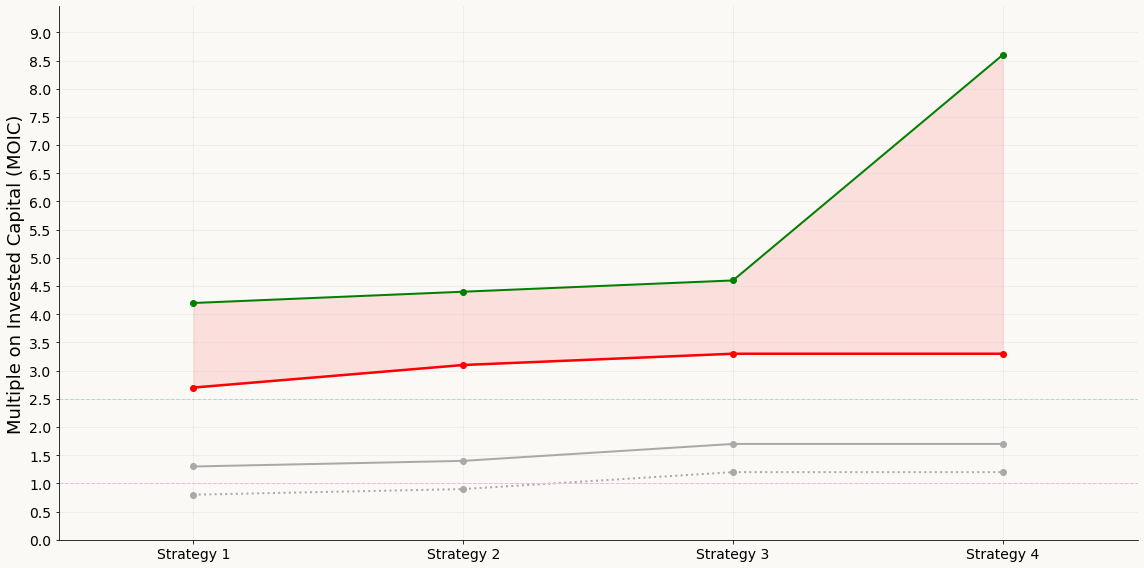


Strategy Details (tab-separated for Excel):
Metric	Strategy 1	Strategy 2	Strategy 3	Strategy 4
Fund Size	$200M	$200M	$200M	$200M
Follow-on Capital Reserved	$60M	$60M	$60M	$60M
Pro-Rata Valuation Threshold	$200M	$200M	$200M	$200M
Initial Pre-seed Check Size	$1.8M	$1.8M	$1.8M	$1.8M
Initial Seed Check Size	$3.5M	$3.5M	$3.5M	$3.5M
Total Pre-seed Capital Deployed	$70M	$70M	$70M	$70M
Total Seed Capital Deployed	$70M	$70M	$70M	$70M
Pre-seed Avg Ownership (initial)	11.67%	11.67%	11.67%	11.67%
Seed Avg Ownership (initial)	11.67%	11.67%	11.67%	11.67%
Overall Ownership (initial)	11.67%	11.67%	11.67%	11.67%
Avg actual portfolio size	60.1	60.0	60.0	60.0
Total # of Portfolio Companies	60	60	60	60
# of Pre-seed Companies (original)	40	40	40	40
# of Seed Companies (original)	20	20	20	20
# of Pre-seed Companies	99,798	80,091	79,737	79,823
# of Seed Companies	100,494	110,224	110,301	110,011
# of Series A Companies	49,891	54,701	55,124	55,163
# of Series B Companies	24,964	27,496	27,593	27,747
# of Seri

In [ ]:
# Base configuration

base_config = {
    'stages': DEFAULT_STAGES,
    'graduation_rates': MARKET,
    'stage_dilution': DEFAULT_STAGE_DILUTION,
    'stage_valuations': DEFAULT_STAGE_VALUATIONS,
    'lifespan_periods': DEFAULT_LIFESPAN_PERIODS,
    'lifespan_years': DEFAULT_LIFESPAN_YEARS,
    'fund_size': 200,
    'num_scenarios': 5000
}

configs = [
    { ## Smarter pro rata 
        **base_config,
        'primary_investments': {'Pre-seed': 70, 'Seed': 70},
        'initial_investment_sizes': {'Pre-seed': 1.75, 'Seed': 3.5},
        'follow_on_reserve': 60,
        'pro_rata_at_or_below': DEFAULT_STAGE_VALUATIONS['Series B']
    },
    { ## Better picker
        **base_config,
        'primary_investments': {'Pre-seed': 70, 'Seed': 70},
        'initial_investment_sizes': {'Pre-seed': 1.75, 'Seed': 3.5},
        'follow_on_reserve': 60,
        'pro_rata_at_or_below': DEFAULT_STAGE_VALUATIONS['Series B']
    },
    { ## Better M&A
        **base_config,
        'primary_investments': {'Pre-seed': 70, 'Seed': 70},
        'initial_investment_sizes': {'Pre-seed': 1.75, 'Seed': 3.5},
        'follow_on_reserve': 60,
        'pro_rata_at_or_below': DEFAULT_STAGE_VALUATIONS['Series B']
    }, 
        { ## Better series G valuation
        **base_config,
        'primary_investments': {'Pre-seed': 70, 'Seed': 70},
        'initial_investment_sizes': {'Pre-seed': 1.75, 'Seed': 3.5},
        'follow_on_reserve': 60,
        'pro_rata_at_or_below': DEFAULT_STAGE_VALUATIONS['Series B']
    }
]

configs[-3]['graduation_rates'] = better_picker
configs[-2]['graduation_rates'] = better_picker_and_seller
configs[-1]['graduation_rates'] = better_picker_and_seller
configs[-1]['stage_valuations'] = STAGE_VALUATIONS_OUTSIZED_SERIES_G
## configs[-2]['graduation_rates'] = better_picker_and_seller

print(configs)
for c in configs:
    print(c)
    print('---------')

# Create Experiment instance
experiment = Experiment()

# Run simulations for each configuration
all_results = []
for i, config in enumerate(configs, 1):
    print(f"Running simulation for Strategy {i}")
    mc_config = experiment.create_montecarlo_sim_configuration(config)
    if mc_config:
        result = experiment.run_montecarlo(mc_config)
        if result:
            result['Strategy'] = f'Strategy {i}'
            all_results.append(result)

# Visualize combined results
experiment.visualize_multiple_strategies(all_results)